# CHEM 60 - February 21st, 2024 (Peak Fitting)

I could have also called today's class "Optimization, Continued" because peak fitting, and frankly, many topics we will cover in our journey through computing in chemistry are simply different optimization problems.

Today, you'll be learning a classic algorithm known as the Gauss-Newton algorithm. It is one of the standard ways that we solve non-linear least squares problems. You likely remember the friendly linear kind we did in [Class 6](https://colab.research.google.com/drive/1LFf3ZArPYL1L1KH86vKz6-nMYfW9vBLy?usp=share_link) to find lines of best fit (the standard tool needed to make a calibration curve or to talk about linear trends in data). For more general problems, we require a more general method (what if we want to fit a curve through non-linear data! We've already tried that, in fact!). Thankfully, this technique has the same fundamental flavour as the linear regression you've done - we need to minimize the residuals (the difference between the observations or "true values" and the prediction from our fit equation). Many of you have asked when we'll get to do machine learning in this course, and guess what? This right here is machine learning (the old-school kind).

To get started, click on '**File**' in the left menu, then '**Save a copy in Drive**' to ensure you are editing *your* version of this assignment (if you don't, your changes won't be saved!). After you click '**Save a copy in Drive**' a popup that says **Notebook copy complete** should appear, and it may ask you to <font color='blue'>**Open in a new tab**</font>. When open, your new file will be named `Copy of CHEM60_Class_10_....ipynb` (you may want to rename it before/after you move it to your chosen directory).

#Imports

Here are the Python imports that we will need today. A tiny bit of default formatting is thrown in here (I like my font sizes to be larger than the default settings).

Run the below code block to get started.

In [1]:
# Standard library imports
import math as m

# Third party imports (a ton of plotting things today!)
import matplotlib.animation as animation
import matplotlib.cm as cm
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.transforms as transforms
from matplotlib import rc

import numpy as np
import pandas as pd
import urllib.request

# so the notebook shows an animation
rc('animation', html='html5')

# This part of the code block is telling matplotlib to make certain font sizes exra, extra large by default
# Here is where I list what parametres I want to set new defaults for
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
# This line updates the default parameters of pyplot (to use our larger fonts)
plt.rcParams.update(params)

First, mount the Drive. You hopefully remember this from week 0. If the details of things like imports or data access need to be clarified, go back and check out the [class 0](https://colab.research.google.com/drive/1q96pdc5CBfjhqkALe-ohqPJwNMcXzwqS?usp=share_link) notebook on this.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Assuming you ended up with `Mounted at /content/gdrive`, you're good to move on!

# The Problem

Today, we are getting to the heart of this course for me: signals, software, and story-telling. We were given the "signals" from Prof. Kathy Van Heuvelen's research group. Prof. Van Heuvelen's research group has been working on bio-inspired inorganic synthesis for pollution remediation.

Perchloroethylene (PCE) and trichloroethylene (TCE) are commonly used industrial chemicals found in everything from metal cleaners to dry cleaning fluids. Unfortunately, these chemicals can end up in our groundwater due to industrial waste. They are harmful to our health, with TCE and PCE categorized as high-level and mid-level cancer-causing substances, respectively.

Extensive use of TCE from the 1940s to the 1970s, in Ontario, California means that those on well-water have water coming into their homes that is unsafe to drink still today (see: "[Trucked-in water just part of life where the toxic plume pollutes Ontario's groundwater](https://www.dailybulletin.com/2016/12/17/trucked-in-water-just-part-of-life-where-the-toxic-plume-pollutes-ontarios-groundwater/)").

Current ways exist to remove these harmful chemicals, but these methods often rely on techniques that can contribute to CO$_2$ emissions. This has motivated Prof.   Van Heuvelen and her students to explore inspiration from the field known as bioremediation, where natural processes are used to return the environment to its original state, to create new solutions for this problem. There are many natural compounds that facilitate dechlorination reactions. Bacterial Cofactor F$_{430}$, a curious Ni-centred structure, has been known to be capable of efficient dechlorination for a number of years, although the exact mechanism by which this cofactor - and related structures - are able to remove halogens is still up for debate. A [paper from 1991](https://drive.google.com/file/d/1KpEhVt5X14h_abg6Lq1ZFsqZFaY1-Phb/view?usp=sharing) on this topic might be interesting for some!

![Figure comparing the structure of Cofactor F430 and a Ni-cyclam, they both have a Ni centre, but the cyclam is smaller overall](https://kavassalis.space/s/KVH_CF430_intro.png)

Prof. Kathy's project aimed to design and synthesize a model compound (something a bit simpler, structure-wise, than Cofactor F$_{430}$) to see how this model compound reacts with contaminants like PCE to better understand what chemical properties are needed to create the ideal remediation scheme.

![Slide from Prof. Van Heuvelen showing a green crystal starting material and a fun pink potentially reduced and active state - we have not yet made it to the dechlorination part!](https://kavassalis.space/s/KVH_slide34.png)
#### Slide from Prof. Van Heuvelen showing the initial goals of the project - start with some starting material, synthesize a good model compound, and then study its reaction with PCE (the contaminant).

But by looking at the reaction products, trying variants with deuterated vs non-deuterated sodium borohydride in the synthesis, performing molecular simulations (you'll learn more about them soon!), and, importantly, examining the IR spectra - they realized something wasn't as it seemed. What actually is the "pink stuff"? If the study requires a model compound, its structure needs to be well characterized!

![Slide from Prof. Van Heuvelen showing their initial assumption as to what compound they synthesized was wrong! This is science!](https://kavassalis.space/s/KVH_slide53.png)
#### Slide from Prof. Van Heuvelen pointing to the mystery - the identify of the model compound they made was called into question.

This brings us to peak-fitting (seriously)! The data from the IR spectra was critical for learning about what they did - or did not - synthesize. How do we take a signal from an IR spectrometer and actually get meaningful information? Obviously, we look for characteristic peaks, but... how? Powerful and efficient software happens onboard most instruments these days to do peak-fitting (but for those of you who have done it before, you may recall you often have to help the software out...).

When I asked Prof. Kathy Van Heuvelen what one figure, one type of data analysis she would love for you to learn how to do it was this right here.

![Slide from Prof. Van Heuvelen showing the IR spectra for the pink compound, two traces appear on the plot, one for the version made with sodium borohydride and one for the version made with deuterated sodium borohydride](https://kavassalis.space/s/KVH_slide57.png)
#### Slide from Prof. Van Heuvelen - the one big thing you should all leave knowing how to do.

How do we make an image like this? *And* how does anyone extract meaning from spectra like this? The steps we walk through apply to far, far more situations than interpreting IR signals (the basic software we'll sketch up can be used to process pretty much any signals with this general appearance).


# Load the Data

Time to load in their data! Thanks to Toty Calvo Polanco (‘21) and Ellie Kim (‘22) for taking these spectra!

We'll load the data as Pandas data frames. Notice that I immediately split the data into two data frames.

In [3]:
# load the dataframe
df = pd.read_csv('/content/gdrive/Shared drives/Chem_60_Spring_2024/In_Class_Notebooks/data/class10_Van_Heuvelen.csv')

# create the first dataframe for IR1
IR1_df = df[['IR1_190627_x', 'IR1_190627_y']].copy()
IR1_df.set_index('IR1_190627_x', inplace=True)
IR1_df.index.name = 'wavenumber'

# create the second dataframe
IR2_df = df[['IR2_190627_x', 'IR2_190627_y']].copy()
IR2_df.set_index('IR2_190627_x', inplace=True)
IR2_df.index.name = 'wavenumber'

## PRACTICE QUESTION

Why did I split it into two data frames?? I recommend looking at the `df` object and the `IR1_df` and `IR2_df` objects below.



---



In [4]:
# how do we look at these again?



---



Let's make a basic plot.

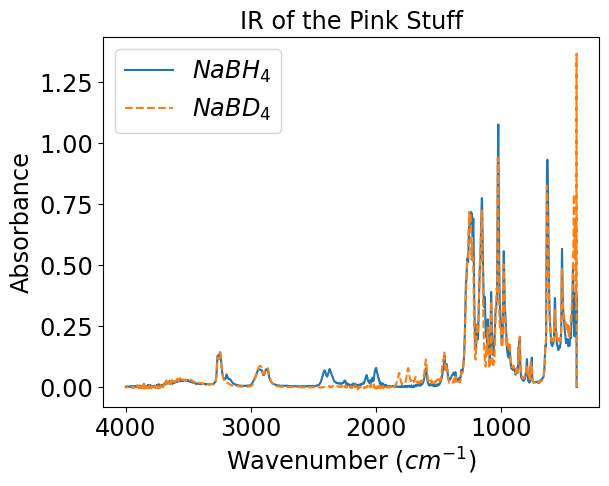

In [5]:
plt.figure()
plt.plot(IR1_df.index, IR1_df['IR1_190627_y'], label='$NaBH_4$')
plt.plot(IR2_df.index, IR2_df['IR2_190627_y'], linestyle='--',label='$NaBD_4$')
plt.xlabel('Wavenumber ($cm^{-1}$)')
plt.ylabel('Absorbance')
plt.title('IR of the Pink Stuff')
plt.gca().invert_xaxis()  # This inverts the x-axis
plt.legend()
plt.show()

Okay. But Prof. Van Heuvelen wanted you to make a fancy plot with an **inset axis**! We can do that easily in matplotlib. Let's look at the syntax:

`ax.inset_axes([x, y, width, height])`

- `x` and `y`: These are the coordinates for the lower left corner of the inset axes. These values are based on a unit system from 0 to 1, where (0, 0) is the bottom left corner of the main axes, and (1, 1) is the top right corner. So, `x = 0.5` and `y = 0.5` indicate that the inset axes will start at the center of the main axes.

- `width` and `height`: These determine the size of the inset axes in the same unit system. So, a `width` of `0.47` means the width of the inset axes will be 47% of the width of the main axes, and likewise for `height`.

By adjusting these four values, you can control exactly where the inset axes appears and how large it is. For example, you might choose to move the inset to the upper right corner of the main axes with `ax.inset_axes([0.5, 0.5, 0.4, 0.4])`, or make it larger with `ax.inset_axes([0.5, 0.5, 0.6, 0.6])`. Experiment with these values until you get a result that looks good to you.

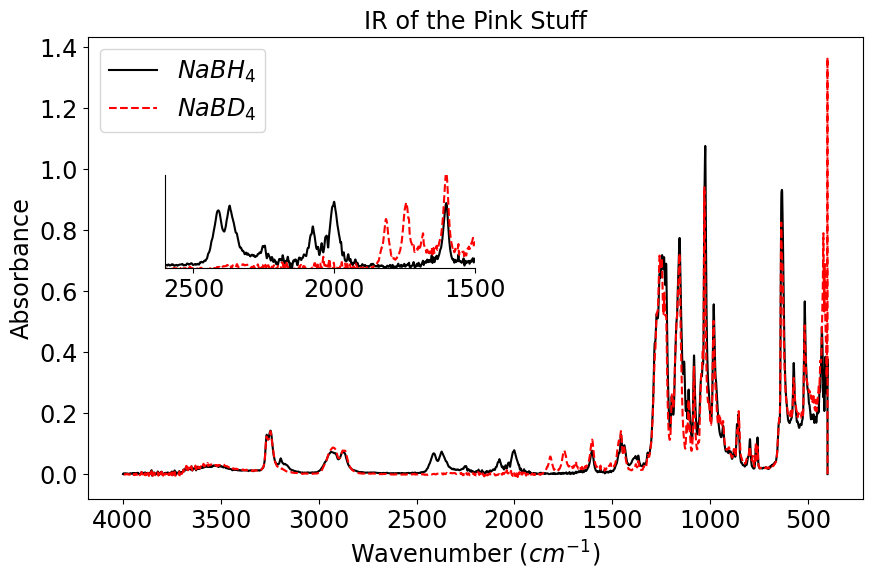

In [6]:
fig, ax = plt.subplots(figsize=(10,6))

# Plot the main figure
ax.plot(IR1_df.index, IR1_df['IR1_190627_y'], color ='k', label='$NaBH_4$')
ax.plot(IR2_df.index, IR2_df['IR2_190627_y'], color ='r', linestyle='--',label='$NaBD_4$')
ax.set_xlabel('Wavenumber ($cm^{-1}$)')
ax.set_ylabel('Absorbance')
ax.set_title('IR of the Pink Stuff')
ax.invert_xaxis()
ax.legend()

# Plot the inset figure
axins = ax.inset_axes([0.1, 0.5, 0.4, 0.2]) ## Look here!!
axins.plot(IR1_df.index, IR1_df['IR1_190627_y'], color ='k', label='$NaBH_4$')
axins.plot(IR2_df.index, IR2_df['IR2_190627_y'],  color ='r', linestyle='--', label='$NaBD_4$')
axins.invert_xaxis()
axins.set_xlim(2600, 1500)
axins.set_ylim(0, .11)
# Remove y-axis ticks
axins.set_yticks([])
# Remove top and right spines
axins.spines['top'].set_visible(False)
axins.spines['right'].set_visible(False)

plt.show()

Not bad. But we can edit it more too!

## PRACTICE QUESTION

Try optimizing this visually. Try moving the legend and dropping the legend frame too. Go for the perfect figure match from the example in the slide above! Look up the syntax options for changing things with `ax.legend()`.


---



In [7]:
# Try making a new version!



---



## Bonus figure modifications

Now, for fun, I'll show you a few more things you can do with this kind of figure. Thomas Fleming ('22) had run some molecular simulations to help with the interpretation of the IR peaks. In the talk that inspired this class, Prof. Kathy walked through different regions of the spectra and overlayed images.

When it comes time for your final project, depending on what you pick, something like this might come up.

I uploaded their images to my website, but you can pull things from any URL with this syntax (and there is a similar variant from pulling images from Drive).

In [8]:
# URLs of the PNG images
url1 = "https://kavassalis.space/s/KVH_2400.png"
url2 = "https://kavassalis.space/s/KVH_2000.png"
url3 = "https://kavassalis.space/s/KVH_2900.png"
url4 = "https://kavassalis.space/s/KVH_3300.png"

# Download the images from the URLs and save them locally
urllib.request.urlretrieve(url1, 'local_image1.png')
urllib.request.urlretrieve(url2, 'local_image2.png')
urllib.request.urlretrieve(url3, 'KVH_2900.png')
urllib.request.urlretrieve(url4, 'KVH_3300.png')

('KVH_3300.png', <http.client.HTTPMessage at 0x7c43e24d4b20>)

(I enjoy stuff like this)

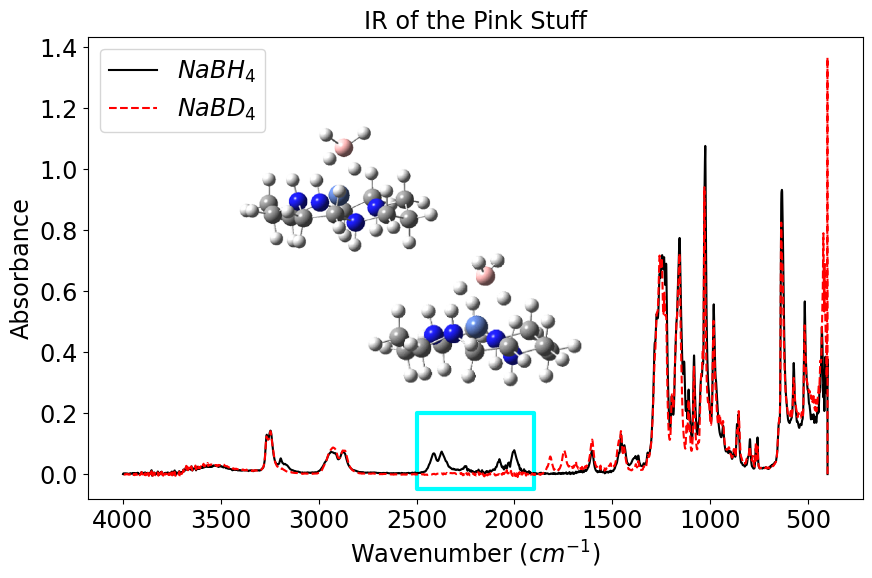

In [9]:
fig, ax = plt.subplots(figsize=(10,6))

# Plot the main figure
ax.plot(IR1_df.index, IR1_df['IR1_190627_y'], color ='k', label='$NaBH_4$')
ax.plot(IR2_df.index, IR2_df['IR2_190627_y'], color ='r', linestyle='--',label='$NaBD_4$')
ax.set_xlabel('Wavenumber ($cm^{-1}$)')
ax.set_ylabel('Absorbance')
ax.set_title('IR of the Pink Stuff')
ax.invert_xaxis()
ax.legend()

# Create a Rectangle patch
rect = patches.Rectangle((1900, -.05), 600, .25, linewidth=3, edgecolor='cyan', facecolor='none',
                         joinstyle='round')
ax.add_patch(rect)

# Load the images from the local files
img1 = mpimg.imread('local_image1.png')
img2 = mpimg.imread('local_image2.png')

# Display the images in the top left corner and the top right corner
imagebox1 = OffsetImage(img1, zoom=0.5)

imagebox2 = OffsetImage(img2, zoom=0.5)
ab1 = AnnotationBbox(imagebox1, (2900, .9), pad=-.1)
ab2 = AnnotationBbox(imagebox2, (2200, .5), pad=-.15)

ax.add_artist(ab2)
ax.add_artist(ab1)


plt.show()

When you give a talk, you often want to step through a figure slowly like this. Sometimes, people make one plot and step through with power point annotations, but if you change the background image/data, you often have to redo all the work. Automating it like this can save a lot of time.

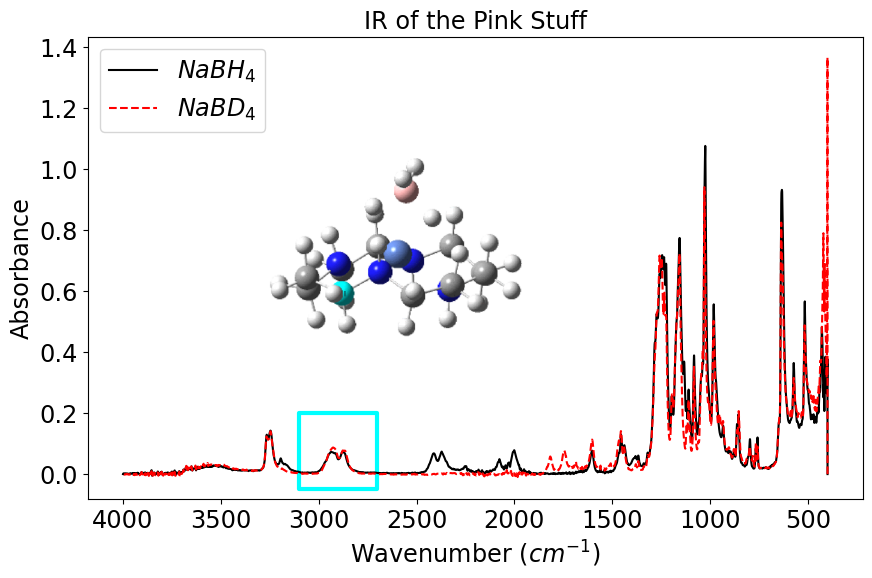

In [10]:
fig, ax = plt.subplots(figsize=(10,6))

# Plot the main figure
ax.plot(IR1_df.index, IR1_df['IR1_190627_y'], color ='k', label='$NaBH_4$')
ax.plot(IR2_df.index, IR2_df['IR2_190627_y'], color ='r', linestyle='--',label='$NaBD_4$')
ax.set_xlabel('Wavenumber ($cm^{-1}$)')
ax.set_ylabel('Absorbance')
ax.set_title('IR of the Pink Stuff')
ax.invert_xaxis()
ax.legend()

# Create a Rectangle patch
rect = patches.Rectangle((2700, -.05), 400, .25, linewidth=3, edgecolor='cyan', facecolor='none',
                         joinstyle='round')
ax.add_patch(rect)

# Load the images from the local files
img1 = mpimg.imread('KVH_2900.png')

# Display the images in the top left corner and the top right corner
imagebox1 = OffsetImage(img1, zoom=0.5)

ab1 = AnnotationBbox(imagebox1, (2600, .7), pad=-.1)

ax.add_artist(ab1)

plt.show()

This was fun.

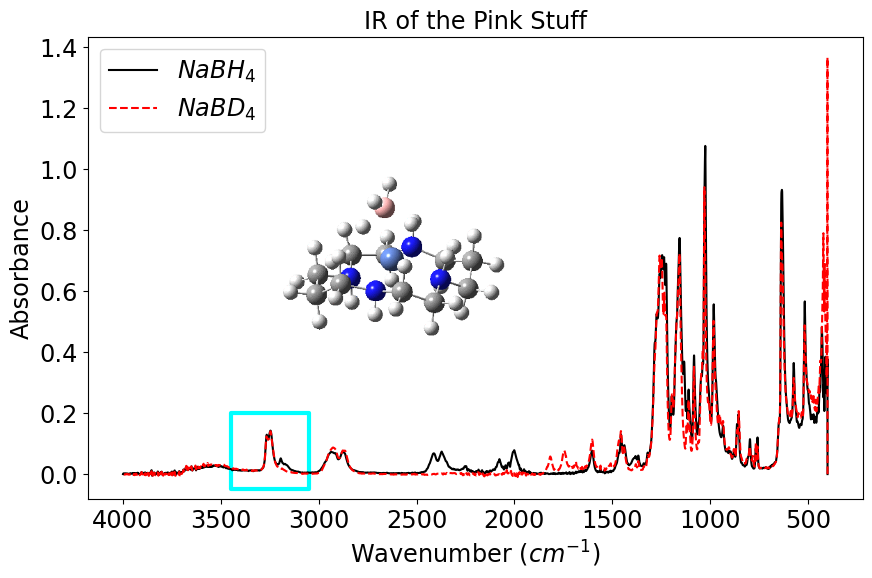

In [11]:
fig, ax = plt.subplots(figsize=(10,6))

# Plot the main figure
ax.plot(IR1_df.index, IR1_df['IR1_190627_y'], color ='k', label='$NaBH_4$')
ax.plot(IR2_df.index, IR2_df['IR2_190627_y'], color ='r', linestyle='--',label='$NaBD_4$')
ax.set_xlabel('Wavenumber ($cm^{-1}$)')
ax.set_ylabel('Absorbance')
ax.set_title('IR of the Pink Stuff')
ax.invert_xaxis()
ax.legend()

# Create a Rectangle patch
rect = patches.Rectangle((3050, -.05), 400, .25, linewidth=3, edgecolor='cyan', facecolor='none',
                         joinstyle='round')
ax.add_patch(rect)

# Load the images from the local files
img1 = mpimg.imread('KVH_3300.png')

# Display the images in the top left corner and the top right corner
imagebox1 = OffsetImage(img1, zoom=0.5)

ab1 = AnnotationBbox(imagebox1, (2600, .7), pad=-.1)

ax.add_artist(ab1)

plt.show()

Okay. Moving on.

# Gauss-Newton

Fundamentally, we don't just look at the figures and say "Ah yes, peaks!". We want to know what wavenumber they appear at, we want to do how tall they are, how wide they are, etc. (I am ignoring the area underneath them today because before we integrate, we actually have to find the peaks!). We also want to do this efficiently. This becomes a non-linear regression problem. Essentially, to automate getting all of the information about where peaks appear and their properties, we need to be able to fit curves to them. One of the most common algorithms to do this (an algorithm inside most instrumental software that produces spectra like this) is known as the Gauss-Newton method.

We'll walk through what it does and how to implement it below.

## Step 1. Define the model for curve fitting

Unlike the linear-least squares, the Gauss-Newton method is general. But we must know in advance what kind of peak shape we seek. The peak shape is a function of the type of detector in our instrument. The majority of instruments are thankfully designed such that we end up with a Gaussian response to a unique signal (but like with everything, you have to understand your application and domain before writing an algorithm).

Let's assume we are using a Gaussian function for curve fitting. This is a reasonable assumption because we have looked at the data we are trying to fit and can imagine it being made up of different Gaussian curves. This is also a good assumption for most instruments you encounter in a typical chemistry laboratory.

In [12]:
def gaussian(x, a, b, c):
    return a * np.exp(-((x - b) ** 2 / (2 * c ** 2)))

### PRACTICE QUESTION
Try to plot a Gaussian curve to remind yourself what the arguments in the above function mean!


---



In [13]:
# I will help you out by saying you need to define an x variable
x = np.linspace(-100,100)
# now you will want to define a y, which will come from the above function (but you'll need arguments for the function)
# then make a quick plot!

## Step 2. Define your residual function

This is again, the difference between observed and estimated data.

In [14]:
def residuals(params, x, y):
    return y - gaussian(x, *params) # look at this cool syntax!

## Step 3. Optimizing time!

The Gauss-Newton algorithm is an optimization approach used to solve non-linear least squares problems. The method approximates the derivative (Jacobian) and Hessian using a first-order Taylor Series approximation. Are these entirely new words? That is okay!

1. Gaussian Function:

$$f(x) = a \cdot e^{-\frac{(x - b)^2}{2c^2}}$$

In this function:
- `x` is your independent variable.
- `a` is a scaling factor, it multiplies the overall height of the curve.
- `b` is the position of the center of the peak.
- `c` determines the width of the bell. A large `c` will create a wide, shallow curve, while a small `c` will create a narrow, steep curve.

2. Jacobian Function:


\begin{align*}
\frac{\partial f}{\partial a} & = e^{-\frac{(x-b)^2}{2c^2}} \\
\frac{\partial f}{\partial b} & = \frac{a \cdot (x-b) \cdot e^{-\frac{(x-b)^2}{2c^2}}}{c^2} \\
\frac{\partial f}{\partial c} & = \frac{a \cdot (x - b)^2 \cdot e^{-\frac{(x-b)^2}{2c^2}}}{c^3}
\end{align*}

The terms in the Jacobian matrix are the derivatives of the Gaussian function with respect to its parameters `a`, `b`, and `c`. The Jacobian matrix represents the rate of change of each function with respect to their corresponding parameters. It is an important part of many algorithms in numerical optimization and is used to perform transformations and changes of variables.

- $\frac{\partial f}{\partial a}$, etc. are partial derivatives of the function with respect to `a`, `b` and `c` respectively.

This information is stored as a matrix



In [15]:
# Let's define our Jacobian
def jacobian(x, params):
    a, b, c = params
    df_da = np.exp(-((x - b) ** 2) / (2 * c ** 2))
    df_db = (a*(x - b)*np.exp(-((x - b)**2)/(2*c**2)))/c**2
    df_dc = (a*(x - b)**2*np.exp(-((x - b)**2)/(2*c**2)))/c**3
    return np.array([df_da, df_db, df_dc]).T

Here's a breakdown of the mathematics involved in the algorith below:

- **Compute residuals**: Residuals are the difference between the observed and predicted values of data. Mathematically, if $y_i$ is the observed value and $f_i$ is the predicted value, the residual $r_i$ is computed as $r_i = y_i - f_i$. This is all well and good.

- **Compute Jacobian**: The Jacobian is a matrix that contains first order partial derivatives of the objective function. It is computed using the `jacobian` function, which we just defined.

- **Compute the Hessian and add regularization term**:
The Hessian matrix is a square matrix that contains the *second order* partial derivatives of a function. It is an important concept in multivariate calculus and plays a critical role in optimization.

For a function f(x, y, ..., z) with n variables, the Hessian matrix H of f is defined as:

```
H = [ H_ij ]
```

where `H_ij` = the second partial derivative of f with respect to the i-th and j-th variable, for all i, j from 1 to n.

For example, the Hessian of a function f(x, y) would be:

```
H = [f_xx  f_xy]
    [f_yx  f_yy]
```

where `f_xx` denotes the second partial derivative of the function with respect to x (`∂²f/∂x²`), `f_xy` denotes the second partial derivative of the function with respect to x and then y (`∂²f/∂x∂y`), and so on.

In the context of optimization, the Hessian matrix is used to determine the nature of the critical points (the points where the derivative is zero) of a function. If the Hessian at a point is positive definite, the function has a local minimum at that point. If the Hessian is negative definite, the function has a local maximum. If the Hessian is indefinite(i.e., some eigenvalues are positive, some are negative), the point is a saddle point.

In the case of the Gauss-Newton method used in our function, the Hessian matrix is approximated using the square of the Jacobian, as the computation of the actual Hessian matrix could be quite expensive for functions with large number of parameters. This is the "first-order taylor expansion" thing I mentioned. We are only approximating the second derivatives, but that approximation is good enough for many problems.


**Compute the parameter updates**: The parameter updates are computed by solving the system of linear equations given by `Hessian.params = -J.T.r.` Here, '@' denotes matrix multiplication and 'np.linalg.inv(Hessian)' calculates the inverse of the Hessian matrix. These parameter updates are then added to the original parameters.

In [16]:
def gauss_newton(x, y, params, max_iter=10, lamb=0.001):
    # Collect costs at each iteration for plotting
    costs = []

    # Collect params at each iteration for plotting
    params_iterative = []

    # Initialize the figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.set_title('Cost vs Iteration')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Cost')

    ax2.set_title('Curve Fit Progress')
    ax2.set_xlabel('x')
    ax2.scatter(x, y, color='red', label='Data')

    # Specify a colormap for plotting
    cmap = plt.colormaps.get_cmap('viridis')

    # Add colorbar to plot corresponding to iteration
    colorbar_ax = fig.add_axes([0.93, 0.10, 0.02, 0.8])
    plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), cax=colorbar_ax, label='Iteration')

    for i in range(max_iter):
        # Compute residuals
        r = residuals(params, x, y)

        # Compute Jacobian
        J = jacobian(x, params)

        # Compute the Hessian and add regularization term
        Hessian = J.T @ J + lamb*np.eye(len(params))

        # Compute the parameter updates
        param_update = np.linalg.inv(Hessian) @ J.T @ r
        params += param_update

        # Add current iteration and cost to plot
        costs.append(np.sum(r**2))
        ax1.plot(range(i+1), costs, 'bo-')

        params_iterative.append(param_update)
        # Add current fit to the second plot
        ax2.plot(x, gaussian(x, *params), color=cmap(i))

    return costs, params_iterative, params

Okay. That might have been a lot. Let's look and see what this does. Can we fit a function to a subset of the IR data? Let's start easy and look at a section with just one peak in it.

Optimized Parameters: [1. 0. 1.]


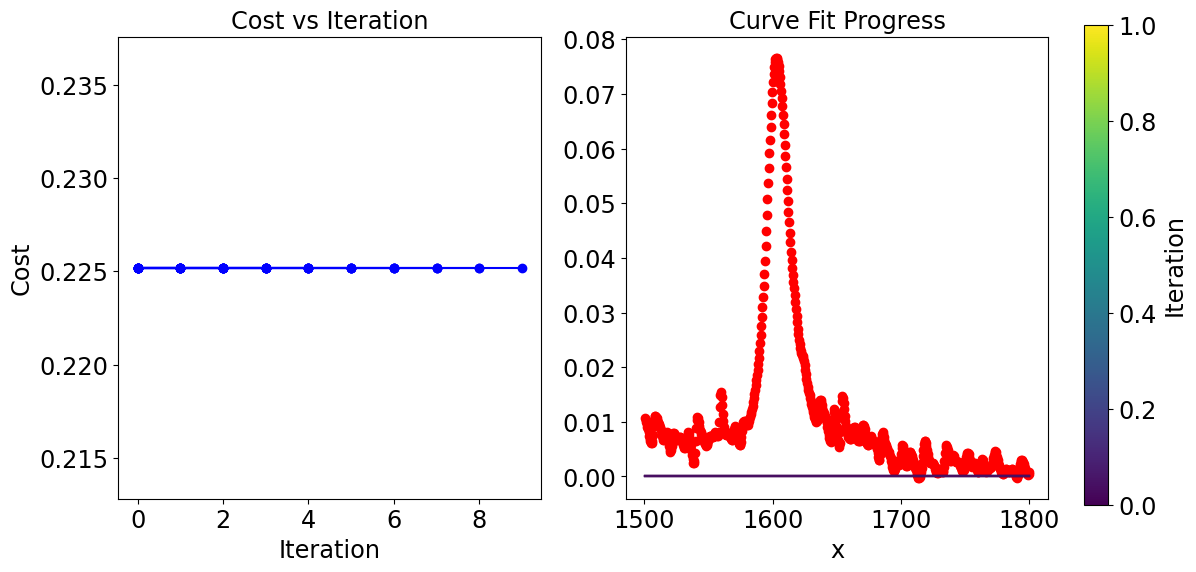

In [17]:
# Filter IR data by a specific wavenumber range
filtered_df = IR1_df[(IR1_df.index >= 1500) & (IR1_df.index <= 1800)]

# the data
x_R1 = filtered_df.index.values
y_R1 = filtered_df['IR1_190627_y'].values


# Set initial parameters
init_params = np.array([1.0, 0.0, 1.0])

# Run our Gauss Newton Optimizer
costs, params_iterative, optimized_params = gauss_newton(x_R1, y_R1, init_params, max_iter=10)
print("Optimized Parameters:", optimized_params)


Wow, that sucked! What happened?

You may recall on Monday that you needed to have decent initial guesses of bond length and angle to do a molecular optimization. Most optimization problems, in fact, require those good initial guesses. Our initial guesses - the paramters we fed into the function were very bad! So bad that we couldn't fit a peak.

Let's try again.

Optimized Parameters: [3.00760242e-02 1.60197641e+03 4.48098267e+01]


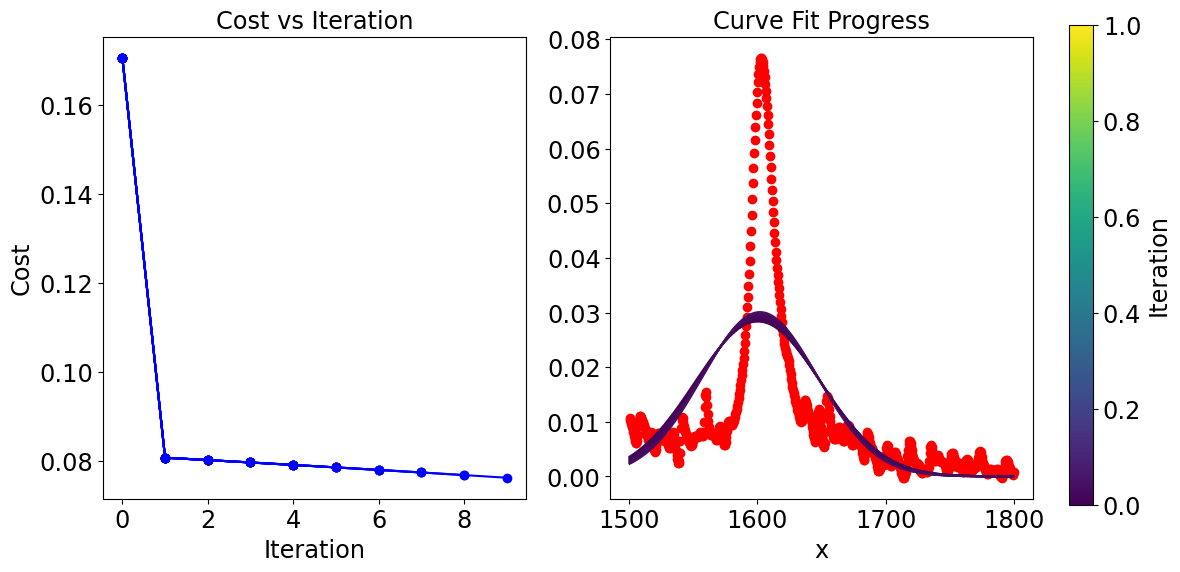

In [18]:
# Set initial parameters
init_params = np.array([0.05, 1600, 50])

# Run our Gauss Newton Optimizer
costs, params_iterative, optimized_params = gauss_newton(x_R1, y_R1, init_params, max_iter=10)
print("Optimized Parameters:", optimized_params)

Hey! We did a thing!

What is happening here? Let's run it for longer!

## PRACTICE QUESTION

Run it for longer! How do we do that?


---



In [19]:
#



---



## PRACTICE QUESTION

Seriously, what is happening here? Talk with your partner? What info are we seeing in each plot?


---



**Notes?**



---

Now let's look at a different window of data.

Optimized Parameters: ([0.14487691602280875, 0.05420973432112411, 0.04993557382843988, 0.04693993795368347, 0.04482965338169986, 0.043336711861087354, 0.042276939533627184, 0.041522635806567065, 0.040984609323867605, 0.0406001974361392], [array([0.02148283, 1.15909181, 0.37494161]), array([-1.92893435e-04,  1.34532268e+00,  3.91146093e-01]), array([-3.85211780e-05,  1.13626276e+00,  2.85378554e-01]), array([-3.32498581e-05,  9.61368761e-01,  2.08450213e-01]), array([-2.67982124e-05,  8.13534182e-01,  1.51937264e-01]), array([-2.08341156e-05,  6.88591144e-01,  1.10327223e-01]), array([-1.56544195e-05,  5.82973291e-01,  7.96387468e-02]), array([-1.13257406e-05,  4.93663174e-01,  5.69860461e-02]), array([-7.80485554e-06,  4.18116895e-01,  4.02672686e-02]), array([-5.00242417e-06,  3.54192315e-01,  2.79439916e-02])], array([7.11307450e-02, 2.90795312e+03, 5.17270170e+01]))


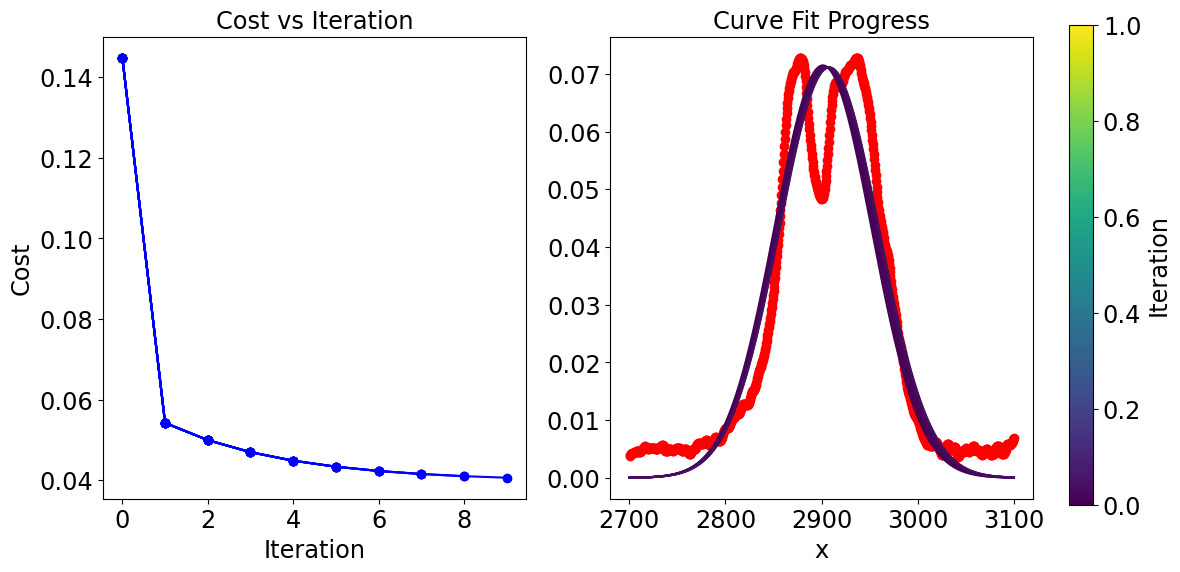

In [20]:
# Filter IR data by a specific wavenumber range
filtered_df = IR1_df[(IR1_df.index >= 2700) & (IR1_df.index <= 3100)]

# the data
x_R2 = filtered_df.index.values
y_R2 = filtered_df['IR1_190627_y'].values

# Set initial parameters
init_params = np.array([0.05, 2900, 50])

# Run our Gauss Newton Optimizer
optimized_params = gauss_newton(x_R2, y_R2, init_params, max_iter=10)
print("Optimized Parameters:", optimized_params)


Oh uh, two peaks that are overlapping! We did not do well here!

But we know this method is general. Let's write a new version. Below, I have written a double Gaussian and its associated Jacobian (first derivatives wrt the parameters).

In [21]:
# Update the Gaussian function to have two peaks
def gaussian_two_peaks(x, a1, b1, c1, a2, b2, c2):
    peak1 = a1 * np.exp(-((x - b1) ** 2 / (2 * c1 ** 2)))
    peak2 = a2 * np.exp(-((x - b2) ** 2 / (2 * c2 ** 2)))
    return peak1 + peak2

# Update the Jacobian accordingly
def jacobian_two_peaks(x, params):
    a1, b1, c1, a2, b2, c2 = params
    df_da1 = np.exp(-((x - b1) ** 2) / (2 * c1 ** 2))
    df_db1 = (a1*(x - b1)*np.exp(-((x - b1)**2)/(2*c1**2)))/c1**2
    df_dc1 = (a1*(x - b1)**2*np.exp(-((x - b1)**2)/(2*c1**2)))/c1**3
    df_da2 = np.exp(-((x - b2) ** 2) / (2 * c2 ** 2))
    df_db2 = (a2*(x - b2)*np.exp(-((x - b2)**2)/(2*c2**2)))/c2**2
    df_dc2 = (a2*(x - b2)**2*np.exp(-((x - b2)**2)/(2*c2**2)))/c2**3
    return np.array([df_da1, df_db1, df_dc1, df_da2, df_db2, df_dc2]).T

And now a new Gauss-Newton function too

In [22]:
# Update Gauss-Newton to use these two peaks function and its Jacobian
def gauss_newton_two_peaks_with_plot(x, y, params, max_iter=10, lamb=0.001):
    # Collect costs at each iteration for plotting
    costs = []
    # Collect params at each iteration for plotting
    params_iterative = []

    # Initialize the figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.set_title('Cost vs Iteration')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Cost')

    ax2.set_title('Curve Fit Progress')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.scatter(x, y, color='red', label='Data')

    # Specify a colormap for plotting
    cmap = plt.colormaps.get_cmap('viridis')

    # Add colorbar to plot corresponding to iteration
    colorbar_ax = fig.add_axes([0.93, 0.10, 0.02, 0.8])
    plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), cax=colorbar_ax, label='Iteration')

    for i in range(max_iter):
        # Compute residuals
        r = y - gaussian_two_peaks(x, *params)

        # Compute Jacobian
        J = jacobian_two_peaks(x, params)

        # Compute the Hessian and add regularization term
        Hessian = J.T @ J + lamb*np.eye(len(params))

        # Compute the parameter updates
        param_update = np.linalg.inv(Hessian) @ J.T @ r
        params += param_update

        # Add current iteration and cost to plot
        costs.append(np.sum(r**2))
        ax1.plot(range(i+1), costs, 'bo-')

        # Add current fit to the second plot
        params_iterative.append([*params])
        ax2.plot(x, gaussian_two_peaks(x, *params), color=cmap(i))

    return costs, params_iterative, params

Let's try it out!

Optimized Parameters for Two Peaks: [6.01095544e-02 2.87065257e+03 2.22028744e+01 7.05728205e-02
 2.93661551e+03 2.91250606e+01]


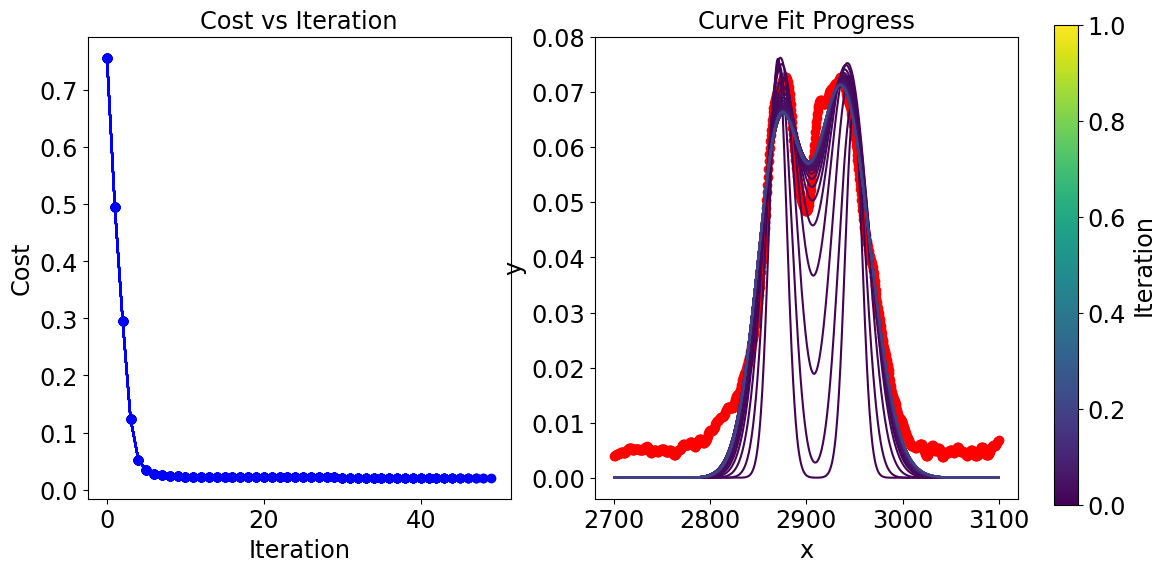

In [23]:
# Set new initial parameters for two peaks
init_params_two_peaks = np.array([0.05, 2870, 5, 0.05, 2950, 5])

# Run Gauss Newton for double peak
costs, params_iterative, optimized_params_two_peaks = gauss_newton_two_peaks_with_plot(x_R2, y_R2, init_params_two_peaks, max_iter=50)
print("Optimized Parameters for Two Peaks:", optimized_params_two_peaks)

Not bad! We can even use the two-peak function for the single peak example (but it is slower to converge).

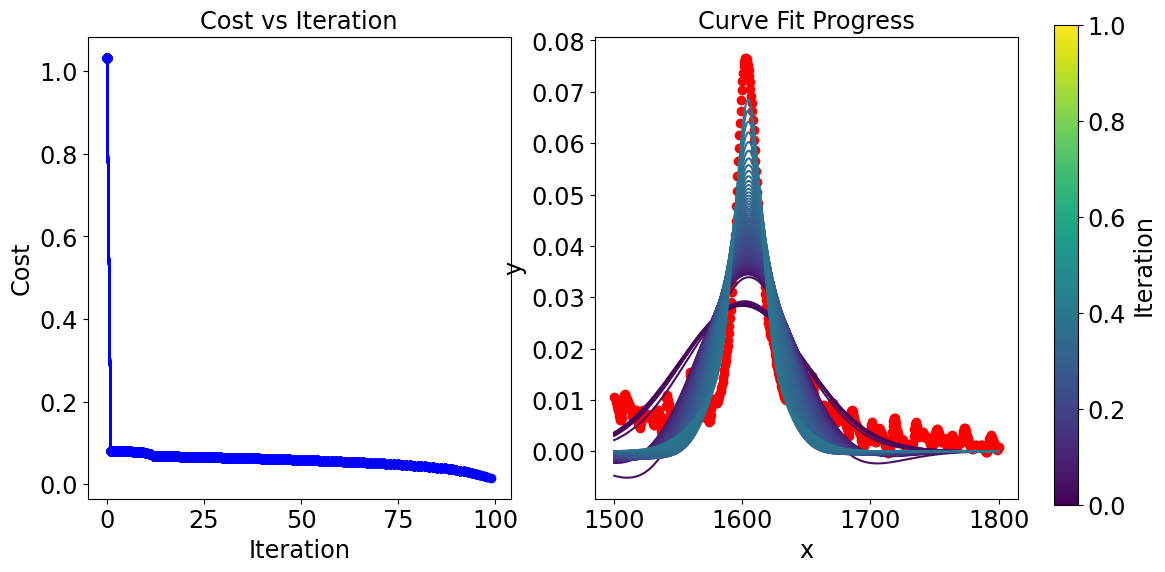

In [24]:
# Set initial parameters
init_params_two_peaks = np.array([0.05, 1600, 50, 0.05, 1600, 50])

# Run Gauss Newton for double peak
costs, params_iterative, optimized_params_two_peaks = gauss_newton_two_peaks_with_plot(x_R1, y_R1, init_params_two_peaks, max_iter=100)

It is a shame we have give it such good initial guesses though!

# Initial Guesses are hard!

Do we really need to have initial guesses? Can't we just search the parameter space?

Let's make a version of our above function that doesn't need to make the plots as we go. This will let us think about how to... optimize this optimization.

In [25]:
def cost_function(params, x, y):
    residuals = y - gaussian_two_peaks(x, *params)
    return np.sum(residuals**2)

def gauss_newton_two_peaks(x, y, params, max_iter=10, lamb=0.001):
    # Collect costs at each iteration for plotting
    costs = []

    # Collect params at each iteration for plotting
    params_iterative = []

    for i in range(max_iter):
        # Compute residuals
        r = y - gaussian_two_peaks(x, *params)

        # Compute Jacobian
        J = jacobian_two_peaks(x, params)

        # Compute the Hessian and add regularization term
        Hessian = J.T @ J + lamb*np.eye(len(params))

        # Compute the parameter updates
        param_update = np.linalg.inv(Hessian) @ J.T @ r
        params += param_update

        # Add current iteration and cost to plot
        costs.append(np.sum(r**2))
        # Add current fit to the second plot
        params_iterative.append([*params])

    return costs, params_iterative, params

Now, let's search the initial guess space for parameters! This will be a bit slow to run.

In [26]:
# Initial guesses ranges for b1 and b2
b1_init_values = np.linspace(2500, 3500, num=50) # Adjust these values as required
b2_init_values = np.linspace(2500, 3500, num=50) # Adjust these values as required

# Initialize a matrix to hold the cost function values
cost_values = np.zeros((len(b1_init_values), len(b2_init_values)))

# Loop over all pairs of initial guesses for b1 and b2
for i, b1_init in enumerate(b1_init_values):
    for j, b2_init in enumerate(b2_init_values):
        # Set the initial parameter guesses
        init_params = np.array([0.05, b1_init, 5, 0.05, b2_init, 5]) # `a1`, `a2`, `c1`, and `c2` are fixed

        # Run the Gauss-Newton optimization
        costs, params_iterative, final_params = gauss_newton_two_peaks(x_R2, y_R2, init_params, max_iter=50)

        # Compute the final cost function value
        cost_values[i,j] = cost_function(final_params, x_R2, y_R2)


Now, let's plot it. Any time you are doing any 'compute' (calculating a thing!). If it takes an appreciable amount of time, don't include the compute in the same code block as the plot. This way, if you want to remake a figure, you don't have to redo the calculation.


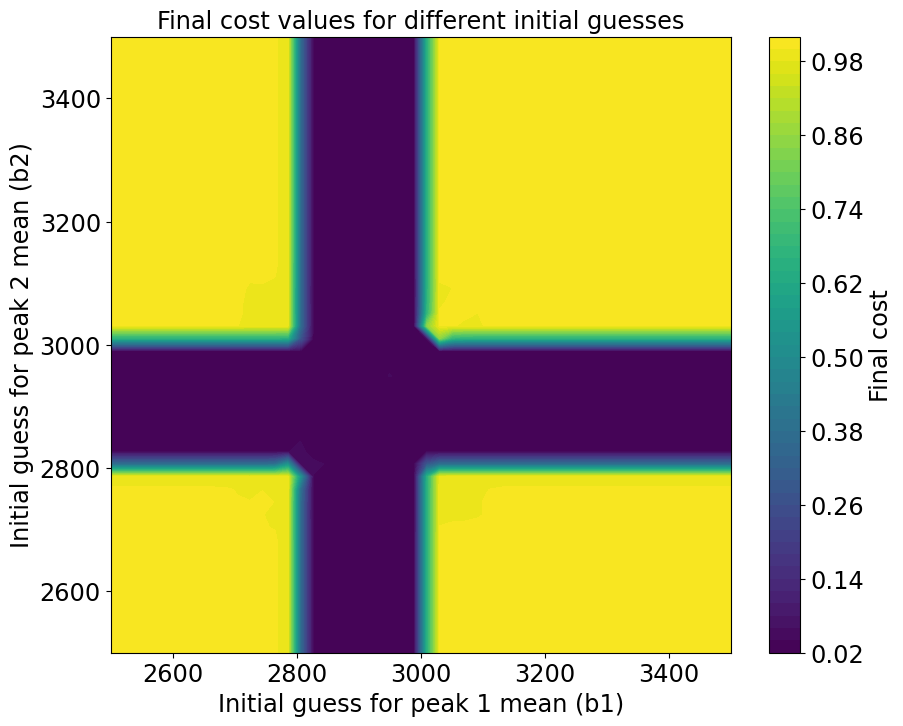

In [27]:
# Set up the contour plot
plt.figure(figsize=(10, 8))
plt.contourf(b1_init_values, b2_init_values, cost_values, levels=50, cmap='viridis')
plt.colorbar(label='Final cost')
plt.xlabel('Initial guess for peak 1 mean (b1)')
plt.ylabel('Initial guess for peak 2 mean (b2)')
plt.title('Final cost values for different initial guesses')
plt.show()

If we denote the length of `b1_init_values` as `N1` and the length of `b2_init_values` as `N2`, and the maximum number of iterations in the Gauss-Newton method as `K`, then running the Gauss-Newton method for each combination of initial parameter guesses would indeed result in an overall runtime complexity of approximately `O(K * N1 * N2)`. And this is only to optimize the position of the peaks!

This means that the computational cost (runtime complexity of the code) scales with the number of maximum iterations as well as the number of grid points for the initial parameter guesses. Therefore, increasing the maximum number of iterations, or increasing the resolution of parameter space you are investigating, will lead to a longer runtime. This is a kind of jargony way to say, we probably don't want to search the entire parameter space every time (it would quickly become extremely costly).

## PRACTICE QUESTION
What is the above figure telling us?? Talk with your partners!



---



**Notes?**



---

You can start with not great guesses though - you just have to run the algorithm for longer to get a decent approximation of your data.

The below will be a bit slow!

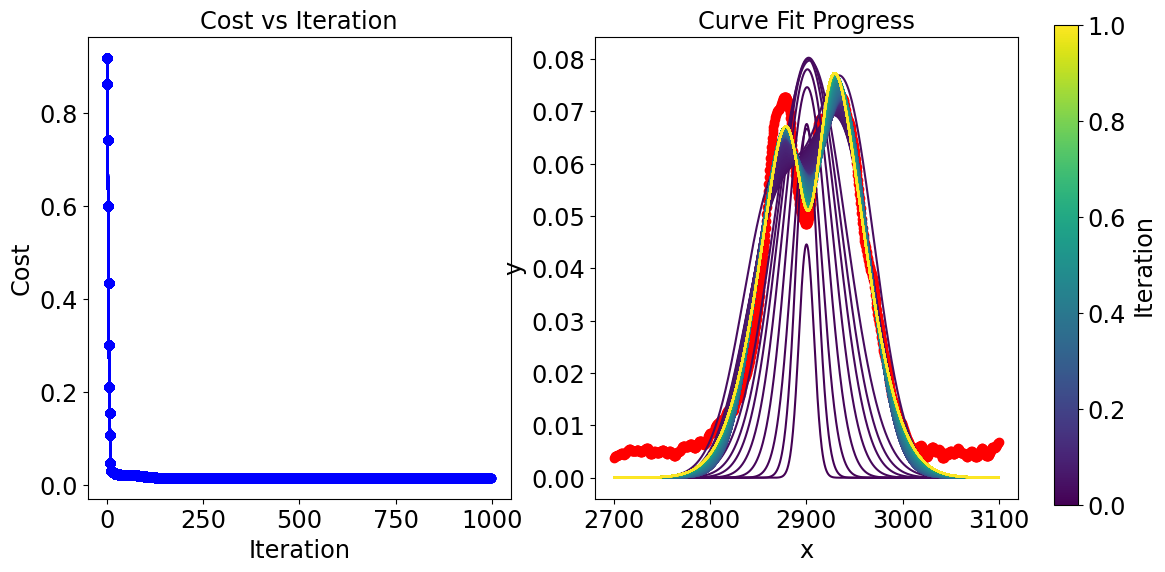

In [28]:
# Set new initial parameters for two peaks
init_params_two_peaks = np.array([0.05, 2900, 5, 0.05, 2900, 5])

# Run Gauss Newton for double peak
optimized_params_two_peaks = gauss_newton_two_peaks_with_plot(x_R2, y_R2, init_params_two_peaks, max_iter=1000)

## Bonus animation

A common way people show visuals of optimizations is through animated plots. The matplotlib syntax is a bit clunky, but this example can be adapater for other purposes.

In [29]:
# Initialization function for the animation
def init():
    ax1.set_xlim(0, max_iterations)
    ax1.set_ylim(0, np.max(costs))
    ax1.set_title('Cost vs Iteration')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Cost')

    ax2.set_xlim(np.min(x_R2), np.max(x_R2))
    ax2.set_ylim(np.min(y_R2), np.max(y_R2))
    ax2.set_title('Curve Fit Progress')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.scatter(x_R2, y_R2, color='red', label='Data')
    return scatter, line,

# Function that will be called on each frame
def update(frame):
    # Clear both plots
    ax1.clear()
    ax2.clear()

    # Set plots properties
    ax2.set_title('Curve Fit Progress')
    ax2.set_xlabel('x')
    ax1.set_xlim(0, max_iterations)
    ax1.set_ylim(0, np.max(costs))
    ax1.set_title('Cost vs Iteration')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Cost')

    # Add each point one by one with a color that corresponds to the current iteration
    for i in range(frame + 1):
        ax1.scatter(i, costs[i], color=cmap(i))

    # Plot the points and new line for the updated frame
    ax2.scatter(x_R2, y_R2, color='red', label='Data')
    ax2.plot(x_R2, gaussian_two_peaks(x_R2, *params_iterative[frame]), color=cmap(frame))

    # Don't forget to reset the labels and title
    ax2.set_title('Curve Fit Progress')
    ax2.set_xlabel('x')

    return scatter,

This is how we run it

In [30]:
max_iterations = 50

# Specify a colormap for plotting
cmap = get_cmap('viridis', max_iterations)

init_params_two_peaks = np.array([0.05, 2900, 5, 0.05, 2900, 5])
costs, params_iterative, optimized_params_two_peaks = gauss_newton_two_peaks(
    x_R2, y_R2, init_params_two_peaks, max_iter=max_iterations)

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Initializing scatter and line object for updating later
scatter = ax1.scatter([], [], color='blue')
line, = ax2.plot([], [], color='blue')

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=max_iterations, init_func=init, blit=True)
plt.close()
ani

<ipython-input-30-ba70c262c00d>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('viridis', max_iterations)


Fun. Let's move on to the next piece of curve fitting.

So, while the Gauss-Newton algorithm can help us find the parameters of peaks (ie. their location and general shape in a spectra) if we have a decent initial guess or patience, the software in our instrument is not complete.

You may have noticed our Gaussians, like Gaussians do, have a 0 baseline (ie. they start and end at 0 on the y-axis). You may also have had some experience with chemical instrumentation that actually asks for your help in correcting the baseline of your data.

Enter: linear regression!

# Baseline Correction

Let's assume our spectra should have a 0-baseline! Let's make it have one!

Read the below code and figure out what it is doing.

In [31]:
# Function for linear baseline
def linear_baseline(x, slope, intercept):
    return slope * x + intercept

# Define function to calculate and subtract baseline
def calculate_and_subtract_baseline(x, y, tail_fraction):
    n = len(x)
    tail_size = int(tail_fraction * n)

    # Compute slope and intercept based on the tails
    x_tails = np.concatenate((x[:tail_size], x[-tail_size:]))
    y_tails = np.concatenate((y[:tail_size], y[-tail_size:]))
    slope = (len(x_tails)*np.sum(x_tails*y_tails)-np.sum(x_tails)*np.sum(y_tails))/(len(x_tails)*np.sum(x_tails**2)-np.sum(x_tails)**2)
    intercept = (np.sum(y_tails)-slope*np.sum(x_tails))/len(x_tails)

    # Subtract the baseline from the original data
    y = y - linear_baseline(x, slope, intercept)
    return x, y, slope, intercept

Let's look at it!

## PRACTICE QUESTION



Talk with your partner! What is this doing?



---



**notes**



---

Now, let's try it out for our two-peak example region. This one already had a kind of decent baseline.

Compute.

In [32]:
# Run Gauss Newton for double peak
init_params_two_peaks = np.array([0.05, 2900, 5, 0.05, 2900, 5])
costs, params_iterative, optimized_params_two_peaks = gauss_newton_two_peaks(x_R2, y_R2, init_params_two_peaks, max_iter=50)

# Correct the baseline applying the function above and define cost function for plots comparison
corrected_x_R2, corrected_y_R2, slope, intercept = calculate_and_subtract_baseline(x_R2, y_R2, 0.1)
init_params_two_peaks = np.array([0.05, 2900, 5, 0.05, 2900, 5])
corrected_costs, params_iterative_corrected, optimized_params_corrected = gauss_newton_two_peaks(corrected_x_R2, corrected_y_R2, init_params_two_peaks, max_iter=50)


And plot!

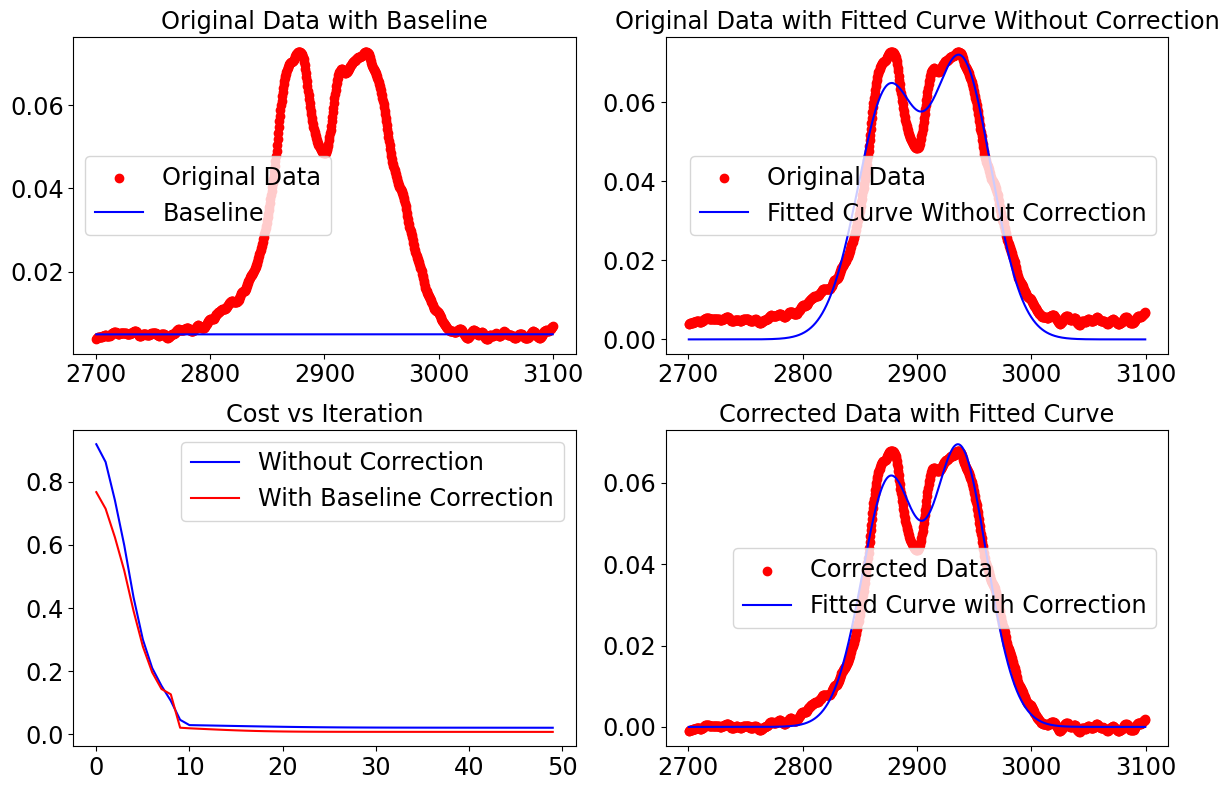

In [33]:
# Set up a figure and axes for the four plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# Plot the original data with the baseline
ax1.scatter(x_R2, y_R2, color='red', label='Original Data')
ax1.plot(x_R2, linear_baseline(x_R2, slope, intercept), color='blue', label='Baseline')
ax1.set_title('Original Data with Baseline')
ax1.legend()

# Execute the method for the uncorrected data and plot it
ax2.scatter(x_R2, y_R2, color='red', label='Original Data')
ax2.plot(x_R2, gaussian_two_peaks(x_R2, *optimized_params_two_peaks), color='blue', label='Fitted Curve Without Correction')
ax2.set_title('Original Data with Fitted Curve Without Correction')
ax2.legend()

# Plot the cost vs iteration for both baseline-corrected and uncorrected data
ax3.plot(range(len(costs)), costs, color='blue', label='Without Correction')
ax3.plot(range(len(corrected_costs)), corrected_costs, color='red', label='With Baseline Correction')
ax3.set_title('Cost vs Iteration')
ax3.legend()

# Plot the baseline-corrected data with the fitted curve
ax4.scatter(corrected_x_R2, corrected_y_R2, color='red', label='Corrected Data')
ax4.plot(corrected_x_R2, gaussian_two_peaks(corrected_x_R2, *optimized_params_corrected), color='blue', label='Fitted Curve with Correction')
ax4.set_title('Corrected Data with Fitted Curve')
ax4.legend()

plt.tight_layout()
plt.show()

## PRACTICE QUESTION

What do you see here?



---



**notes**



---

Now let's try it for the one peak region!

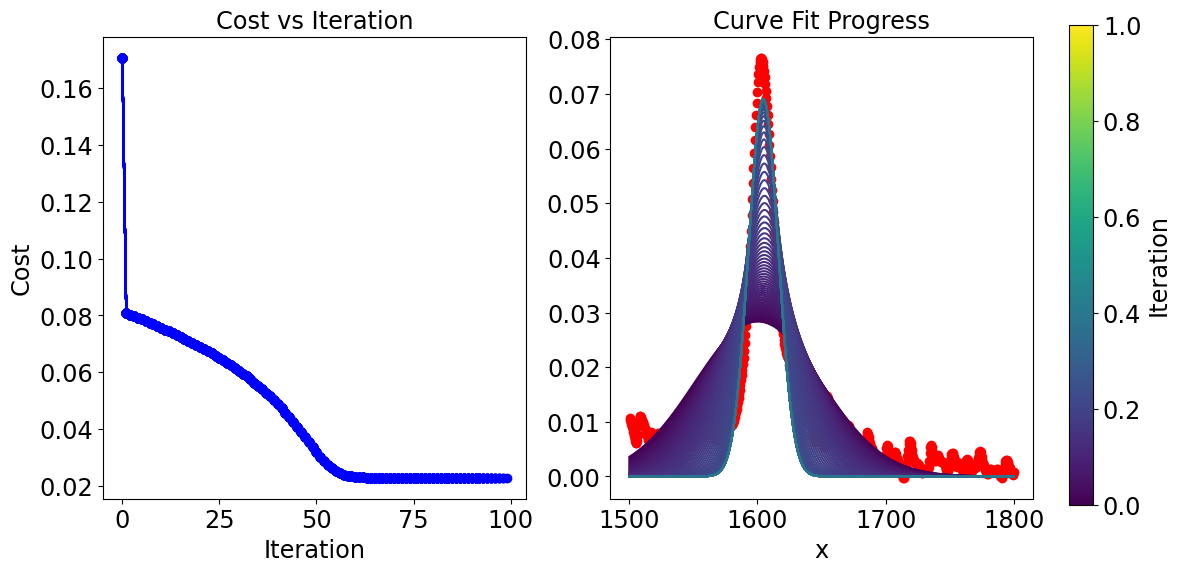

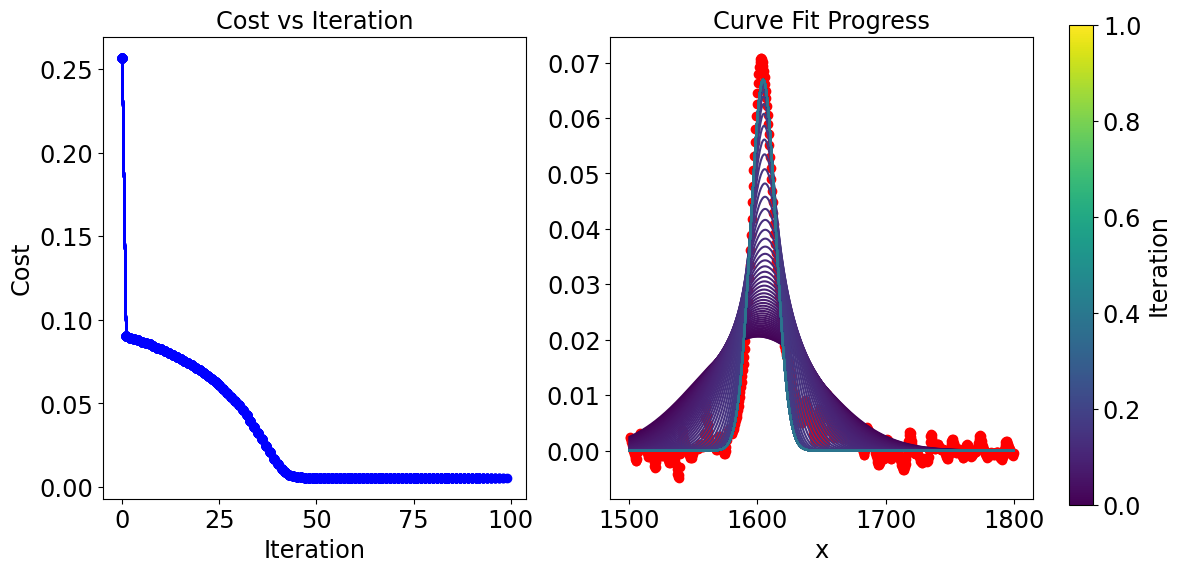

In [34]:
# Run Gauss Newton for double peak
init_params = np.array([0.05, 1600, 50])
costs, params_iterative, optimized_params = gauss_newton(x_R1, y_R1, init_params, max_iter=100)

# Correct the baseline applying the function above and define cost function for plots comparison
corrected_x_R1, corrected_y_R1, slope, intercept = calculate_and_subtract_baseline(x_R1, y_R1, 0.1)
init_params = np.array([0.05, 1600, 50])
corrected_costs, params_iterative_corrected, optimized_params_corrected = gauss_newton(corrected_x_R1, corrected_y_R1, init_params, max_iter=100)


Let's look at the benefit of a baseline correction here!

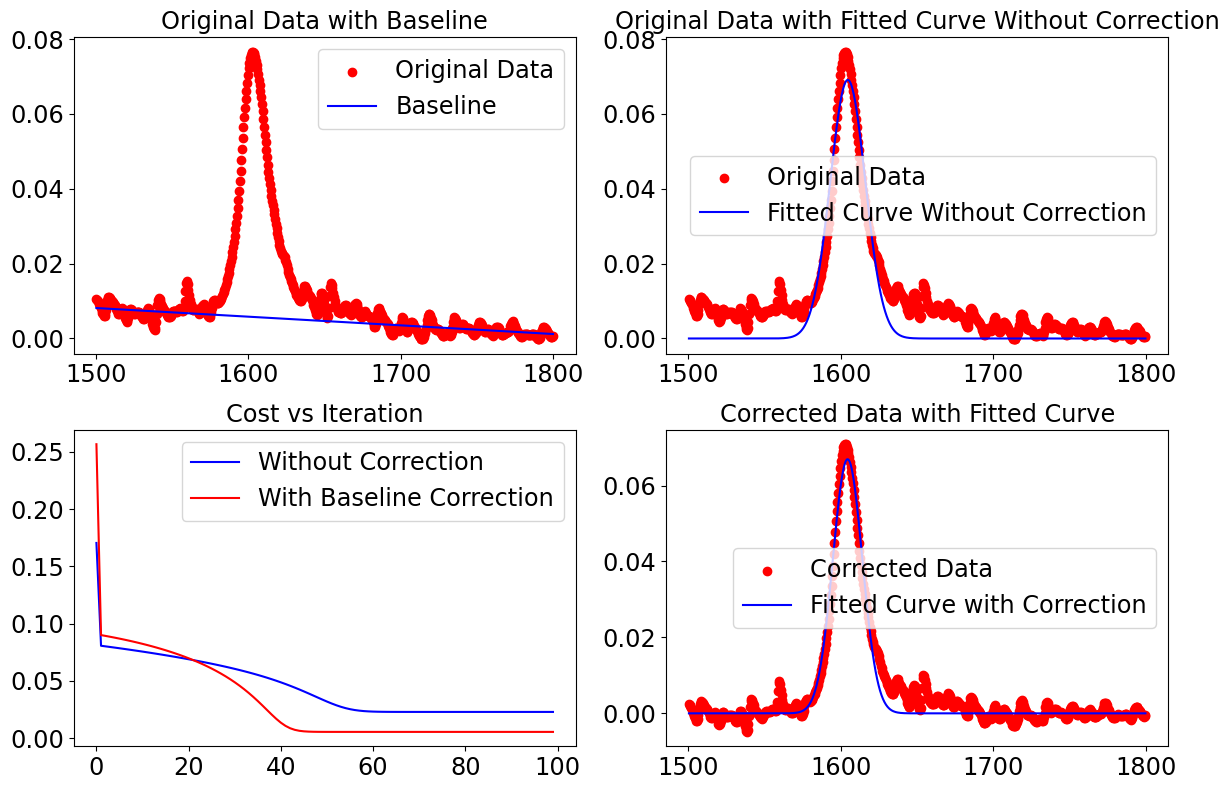

In [35]:
# Set up a figure and axes for the four plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# Plot the original data with the baseline
ax1.scatter(x_R1, y_R1, color='red', label='Original Data')
ax1.plot(x_R1, linear_baseline(x_R1, slope, intercept), color='blue', label='Baseline')
ax1.set_title('Original Data with Baseline')
ax1.legend()

# Execute the method for the uncorrected data and plot it
ax2.scatter(x_R1, y_R1, color='red', label='Original Data')
ax2.plot(x_R1, gaussian(x_R1, *optimized_params), color='blue', label='Fitted Curve Without Correction')
ax2.set_title('Original Data with Fitted Curve Without Correction')
ax2.legend()

# Plot the cost vs iteration for both baseline-corrected and uncorrected data
ax3.plot(range(len(costs)), costs, color='blue', label='Without Correction')
ax3.plot(range(len(corrected_costs)), corrected_costs, color='red', label='With Baseline Correction')
ax3.set_title('Cost vs Iteration')
ax3.legend()

# Plot the baseline-corrected data with the fitted curve
ax4.scatter(corrected_x_R1, corrected_y_R1, color='red', label='Corrected Data')
ax4.plot(corrected_x_R1, gaussian(corrected_x_R1, *optimized_params_corrected), color='blue', label='Fitted Curve with Correction')
ax4.set_title('Corrected Data with Fitted Curve')
ax4.legend()

plt.tight_layout()
plt.show()

Okay. Now, what do we see?


## PRACTICE QUESTION

How important do you think baseline corrections are? When should it occur in our software? (P.S. You will be putting all these pieces together in your homework, so... you will want to decide that!)

---



**notes**



---

Now, getting back to the question of how we find our peaks without first knowing where they were.

# Peak Localization

Okay. A comment that several of you have written or said to me is... where does the code in these Weird Wednesday™ notebooks come from (Answer: my brain!). But it doesn't come out doing what I want it to do the very first time I write it. In fact, designing a new code base, a new piece of software, a new function, is itself an optimization process.

In this next section, I am going to show you how I iterated on the function to actually find the location of the peaks so you can see my process.

The main goal: Write a function to find peaks, knowing that peaks are places where the function's derivative is roughly zero! To be real peaks, the mean y-value of the peak should probably be a standard deviation greater than the mean value of the surrounding region.



## PRACTICE QUESTION
First. Does that logic make sense?


---



**notes**



---

Here was my first attempt.


In [36]:
def find_significant_peaks(y, derivative_threshold, standard_deviations):
    # Calculate the approximate derivative
    dy = np.diff(y)

    flat_regions = np.abs(dy) < derivative_threshold

    # Create an array to store the peaks
    peaks = []

    # We start at 1 because we will be looking at the previous value
    for i in range(1, len(y) - 1):
        if flat_regions[i-1] and dy[i] >= derivative_threshold:
            # We are at the start of a peak
            start = i
        elif flat_regions[i-1] and dy[i] < -derivative_threshold:
            # We are at the end of a peak
            end = i

            # Identify the highest point within this peak
            region = y[start : end]
            mean = np.mean(region)
            std_dev = np.std(region)

            # A local maximum is a point higher than the mean
            # by a certain number of standard deviations
            local_max = mean + standard_deviations*std_dev

            for j in range(start, end):
                if y[j] > local_max:
                    peaks.append(j)

    return peaks

Now, I tried to use it for the one peak example!

In [37]:
peaks = find_significant_peaks(corrected_y_R1, 0.001, 1)
print(peaks)

[123, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 319]


That... appears to be many numbers! I was expecting one!

Let's plot it to see what it found.

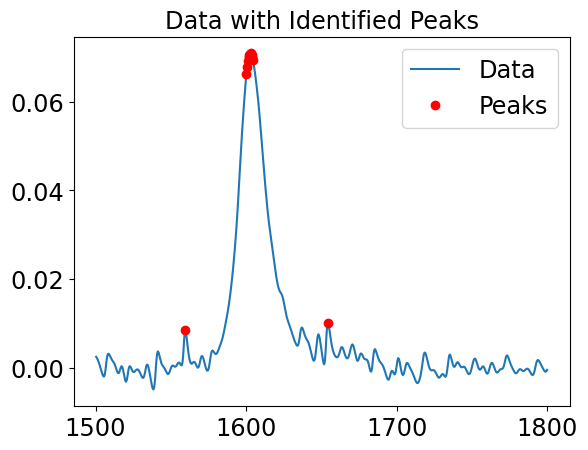

In [38]:
# Create the figure and axes
fig, ax = plt.subplots()

# Plot the data points
ax.plot(x_R1, corrected_y_R1, label='Data')

# Plot the peaks
ax.plot([x_R1[i] for i in peaks], [corrected_y_R1[i] for i in peaks], 'ro', label='Peaks')

ax.set_title('Data with Identified Peaks')
ax.legend()

plt.show()

Oh. That *is* many things! Whoops.

Okay, so, why? First, my function was trying to find 'flat' regions - ie. places with small derivatives. What did it really find? Let's make a new plot!

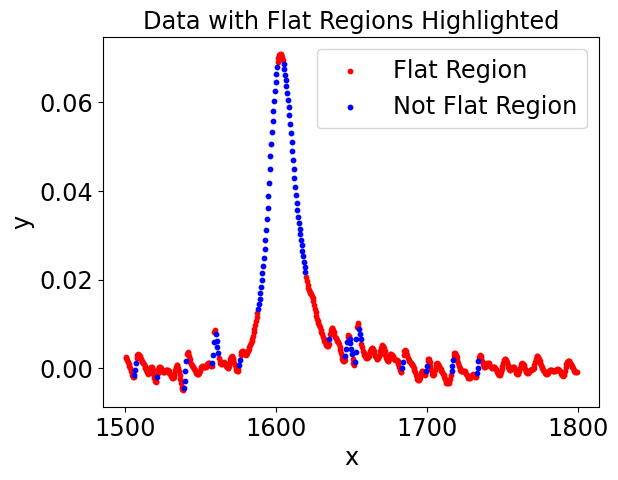

In [39]:
derivative_threshold = 0.001
dy = np.diff(corrected_y_R1)
flat_regions = np.abs(dy) < derivative_threshold

# Create the figure and axes
fig, ax = plt.subplots()

# Separate the 'flat' and 'not flat' data
x_flat = x_R1[:-1][flat_regions]
y_flat = corrected_y_R1[:-1][flat_regions]
x_not_flat = x_R1[:-1][~flat_regions]
y_not_flat = corrected_y_R1[:-1][~flat_regions]

# Plot the data points, colored by whether they are in a flat region
ax.scatter(x_flat, y_flat, color='red', label='Flat Region', s=10)
ax.scatter(x_not_flat, y_not_flat, color='blue', label='Not Flat Region', s=10)

# Providing labels and title for the plot
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Data with Flat Regions Highlighted')
ax.legend()

plt.show()

Yes okay, so that is very wrong. Let's try something else. Before, I was looking for some specific threshold for the derivative (but derivatives with discrete data are notoriously hard to pin down), but what if I tried a relative value?

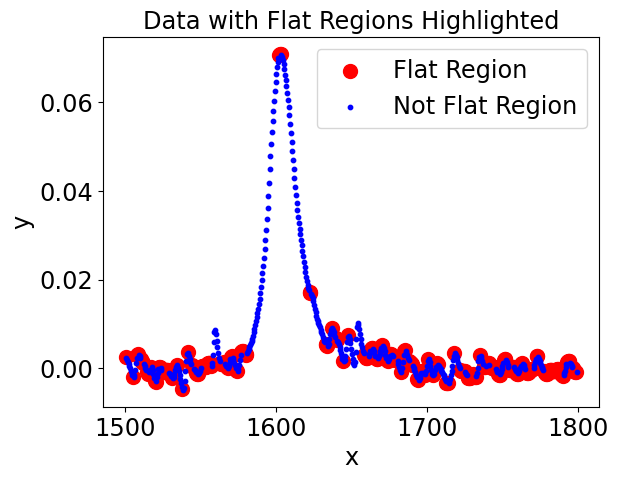

In [40]:
relative_derivative_threshold = 0.1  # Set to 10% of maximum change in y

# Calculate derivative
dy = np.diff(corrected_y_R1)

# Find maximum change in y
max_dy = np.max(np.abs(dy))

# Set derivative threshold relative to the maximum change
derivative_threshold = relative_derivative_threshold * max_dy

# Identify flat regions where change in y is less than threshold
flat_regions = np.abs(dy) < derivative_threshold

fig, ax = plt.subplots()

# Separate the 'flat' and 'not flat' data
x_flat = x_R1[:-1][flat_regions]
y_flat = corrected_y_R1[:-1][flat_regions]
x_not_flat = x_R1[:-1][~flat_regions]
y_not_flat = corrected_y_R1[:-1][~flat_regions]

# Plot the data points, colored by whether they are in a flat region
ax.scatter(x_flat, y_flat, color='red', label='Flat Region', s=100)
ax.scatter(x_not_flat, y_not_flat, color='blue', label='Not Flat Region', s=10)

# Providing labels and title for the plot
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Data with Flat Regions Highlighted')
ax.legend()

plt.show()

Ooh, much better! Let's rewrite the function now.

In [41]:
def find_significant_peaks(y, derivative_threshold_percent, standard_deviations):
    # Calculate the approximate derivative
    dy = np.abs(np.diff(y))

    # Find maximum change in y and set derivative threshold relative to the maximum change
    max_dy = np.max(dy)
    derivative_threshold = derivative_threshold_percent * max_dy

    peaks = []
    start = None

    for i in range(1, len(y)):
        if dy[i-1] < derivative_threshold and start is None:
            # We are at the start of a peak
            start = i
        elif dy[i-1] >= derivative_threshold and start is not None:
            # We are at the end of a peak
            end = i
            peak_region = y[start : end]

            # Identify adjacent regions
            left_region = y[max(0, start-10):start]
            right_region = y[end:min(end+10,len(y)-1)]

            # Calculate adjacency mean and stddev
            adjacency_values = np.concatenate((left_region,right_region))
            adjacency_mean = np.mean(adjacency_values)
            adjacency_stddev = np.std(adjacency_values)

            # Check if peak mean is significantly greater than adjacent regions' mean
            if np.mean(peak_region) + standard_deviations*np.std(peak_region) > adjacency_mean + standard_deviations*adjacency_stddev:
                peak_index = np.argmax(peak_region) + start
                peaks.append(peak_index)

            start = None  # Reset the start point for the next peak

    return peaks

And test it again.

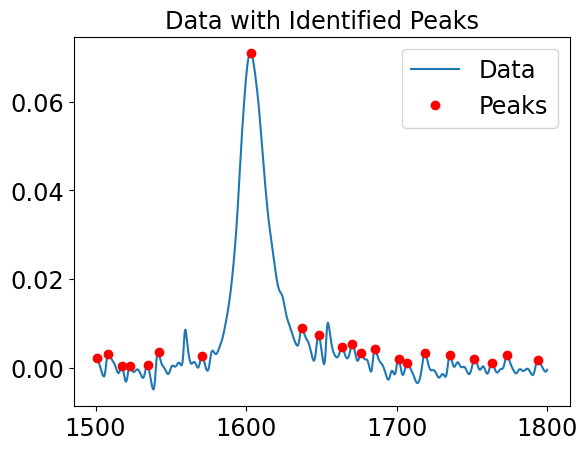

In [42]:
peaks = find_significant_peaks(corrected_y_R1, 0.1, 1)

fig, ax = plt.subplots()
ax.plot(x_R1, corrected_y_R1, label='Data')
ax.plot([x_R1[i] for i in peaks], [corrected_y_R1[i] for i in peaks], 'ro', label='Peaks')
ax.set_title('Data with Identified Peaks')
ax.legend()
plt.show()

Improvement!! We found the one main peak, but also the small noise peaks. Why didn't my standard deviation limit prevent me from finding those?

In [43]:
len(x_R1)

622

I am looking at +/- 10 points on either side for this assessment. In this small sample of data, that is a tiny percent and maybe not sufficient. Let's make this something I can vary.

In [44]:
def find_significant_peaks(y, derivative_threshold_percent, standard_deviations, region_radius):
    # Calculate the approximate derivative
    dy = np.abs(np.diff(y))

    # Find maximum change in y and set derivative threshold relative to the maximum change
    max_dy = np.max(dy)
    derivative_threshold = derivative_threshold_percent * max_dy

    peaks = []
    start = None

    for i in range(1, len(y)):
        if dy[i-1] < derivative_threshold and start is None:
            # We are at the start of a flat region
            start = i
        elif dy[i-1] >= derivative_threshold and start is not None:
            # We are at the end of a flat region
            end = i

            # Verify position allows for a full surrounding region
            if start - region_radius >= 0 and end + region_radius < len(y):
                # Identify region and calculate mean and standard deviation
                region = y[start : end]
                region_mean = np.mean(region)
                region_stddev = np.std(region)

                # Identify surrounding region
                surrounding_region = np.concatenate((y[start-region_radius:start], y[end:end+region_radius]))
                surrounding_mean = np.mean(surrounding_region)
                surrounding_stddev = np.std(surrounding_region)

                # Check if the region mean is significantly greater than the mean of the surrounding regions
                if region_mean + standard_deviations*region_stddev > surrounding_mean + standard_deviations*surrounding_stddev:
                    # Find maximum value within region as the peak
                    peak_index = start + np.argmax(region)
                    # Append the index of the peak value to the list
                    peaks.append(peak_index)

            start = None

    return peaks

Let's try varying things!

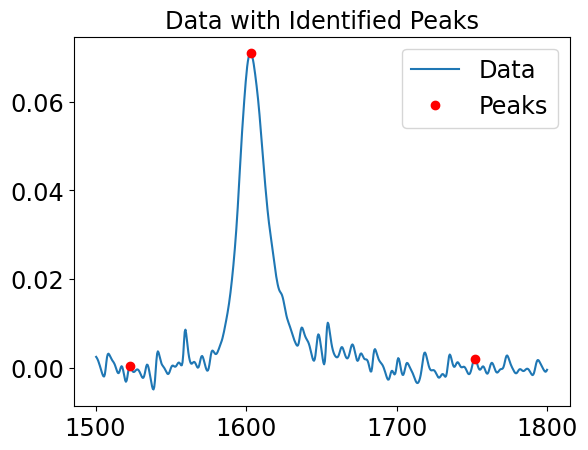

In [45]:
region_radius = 20  # Define distance on either side of region to include in comparison
peaks = find_significant_peaks(corrected_y_R1, 0.01, 1, region_radius)

fig, ax = plt.subplots()
ax.plot(x_R1, corrected_y_R1, label='Data')
ax.plot([x_R1[i] for i in peaks], [corrected_y_R1[i] for i in peaks], 'ro', label='Peaks')
ax.set_title('Data with Identified Peaks')
ax.legend()
plt.show()

That already is a huge improvement! We found two noise peaks though! Can I optimize this region size?

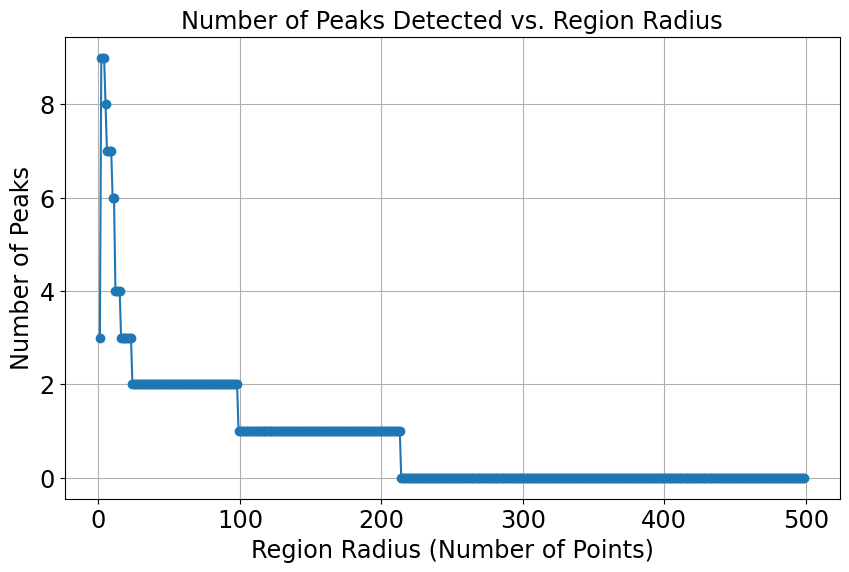

In [46]:
# Range of region_radius values to explore
region_sizes = range(1, 500)

# List to save the number of peaks found
peak_counts = []

# Loop over region sizes
for size in region_sizes:
    peaks = find_significant_peaks(corrected_y_R1, 0.01, 1, size)
    peak_counts.append(len(peaks))

# Create a plot of region_radius versus number of peaks found
plt.figure(figsize=(10,6))
plt.plot(region_sizes, peak_counts, marker='o')
plt.xlabel('Region Radius (Number of Points)')
plt.ylabel('Number of Peaks')
plt.title('Number of Peaks Detected vs. Region Radius')
plt.grid(True)

plt.show()

## PRACTICE QUESTION
What is the above telling me??


---



**notes**



---

A particular value looked good to me (100). Why?


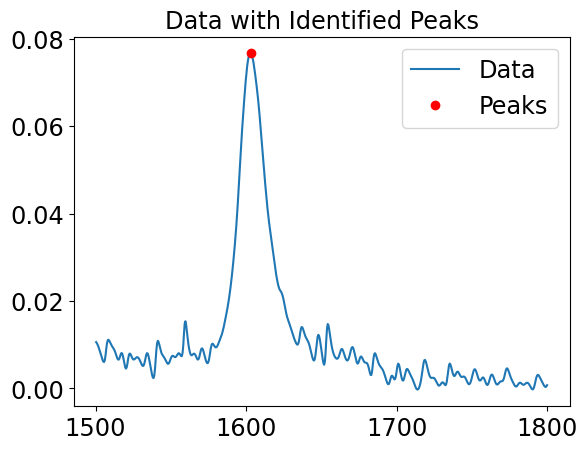

In [47]:
region_radius = 100  # Define distance on either side of region to include in comparison

peaks = find_significant_peaks(y_R1, 0.01, 1, region_radius)

fig, ax = plt.subplots()
ax.plot(x_R1, y_R1, label='Data')
ax.plot([x_R1[i] for i in peaks], [y_R1[i] for i in peaks], 'ro', label='Peaks')
ax.set_title('Data with Identified Peaks')
ax.legend()
plt.show()

Yay! We wanted one peak and found it! Let's look at our two peak example.


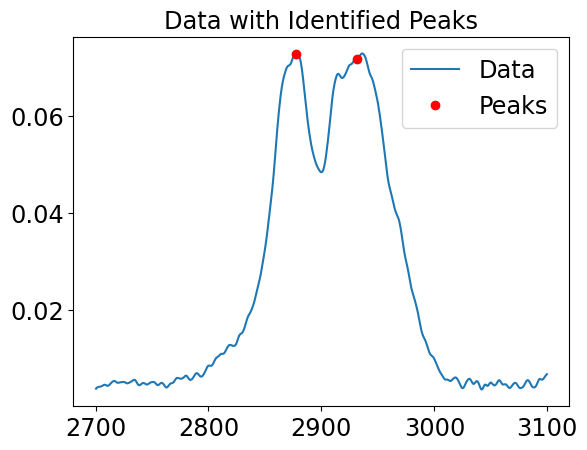

In [48]:
peaks = find_significant_peaks(y_R2, 0.01, 1, region_radius)

fig, ax = plt.subplots()
ax.plot(x_R2, y_R2, label='Data')
ax.plot([x_R2[i] for i in peaks], [y_R2[i] for i in peaks], 'ro', label='Peaks')
ax.set_title('Data with Identified Peaks')
ax.legend()
plt.show()

Also yay!

But we have two arguments here - standard deviation and this neighbourhood side to compare with. Let's try optimizing both together.

Looking at the one peak example.

Compute.

In [49]:
# Define range of region_radius and standard_deviations values to explore
region_sizes = range(1, 500)
std_devs = np.arange(0.5, 5.5, 0.5)

# Initialize a matrix to save the number of peaks found
peak_counts_R1 = np.zeros((len(region_sizes), len(std_devs)))

# Initialize a list to store pairs (region_size, std_dev) that result in 1 peak
optimal_pairs_R1 = []

# Loop over region sizes and standard deviations
for i, size in enumerate(region_sizes):
    for j, std_dev in enumerate(std_devs):
        peaks = find_significant_peaks(y_R1, 0.01, std_dev, size)
        peak_counts_R1[i, j] = len(peaks)
        # If the number of peaks is exactly 1, save the region size and std_dev pair
        if peak_counts_R1[i, j] == 1:
            optimal_pairs_R1.append((std_dev, size))


And plot!

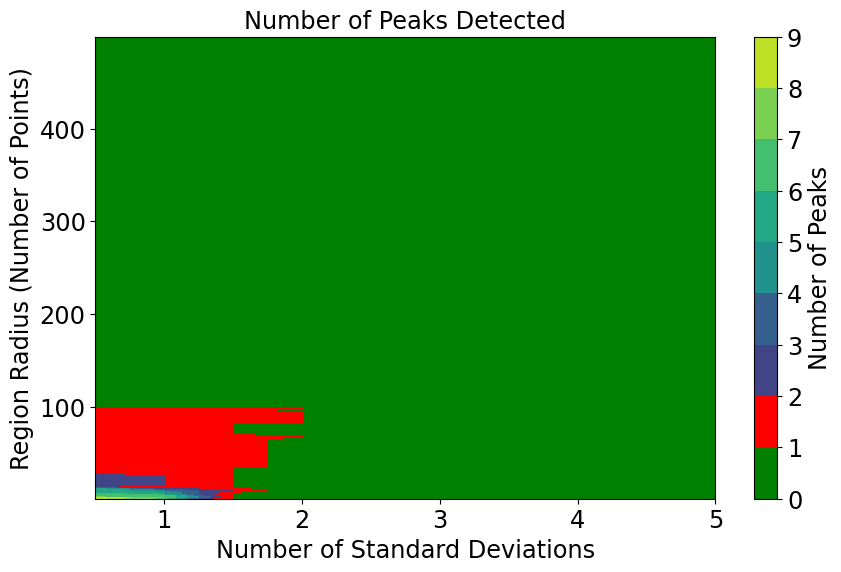

In [50]:
# Find maximum number of peaks detected in any region
max_peaks = int(peak_counts_R1.max()+1)

# Colour mapping <- I did a weird thing here!
colour_list = ["green", "red"] + [cm.viridis(i/max_peaks) for i in range(2, max_peaks)]
cmap_R1 = mcolors.LinearSegmentedColormap.from_list("custom", colour_list, N=max_peaks)

# Create a contour plot of region_radius and std_dev vs. number of peaks found
plt.figure(figsize=(10,6))
plt.contourf(std_devs, region_sizes, peak_counts_R1, levels=max_peaks, cmap=cmap_R1)
plt.xlabel('Number of Standard Deviations')
plt.ylabel('Region Radius (Number of Points)')
plt.title('Number of Peaks Detected')
plt.colorbar(label='Number of Peaks')
plt.show()

What a weird plot, Prof. Kavassalis! (I can only assume you were thinking). How about you make it nicer looking?

This line:

```
# Colour mapping <- I did a weird thing here!
colour_list = ["green", "red"] + [cm.viridis(i/max_peaks) for i in range(2, max_peaks)]
```

is creating a custom colour map to make the 0 and 1 peak cases clearly distinct from each other and from the rest. *Why?*

Also, these colours are awful! Red and green are not colour-blind friendly choices to pair together. This website: https://colorbrewer2.org/#type=qualitative is where I typically select my colour schemes. I recommend you find one that is more accessible and will help you see the critical information. Make sure you know the purpose of this plot and fix the colours!

## PRACTICE QUESTION

Make the plot better!


---



In [51]:
#



---

Let's look at the optimization from the two peak case.

Compute.

In [52]:
# Initialize a matrix to save the number of peaks found
peak_counts_R2 = np.zeros((len(region_sizes), len(std_devs)))

# Initialize a list to store pairs (region_size, std_dev) that result in 1 peak
optimal_pairs_R2 = []

# Loop over region sizes and standard deviations
for i, size in enumerate(region_sizes):
    for j, std_dev in enumerate(std_devs):
        peaks = find_significant_peaks(y_R2, 0.01, std_dev, size)
        peak_counts_R2[i, j] = len(peaks)
        # If the number of peaks is exactly 2, save the region size and std_dev pair
        if peak_counts_R2[i, j] == 2:
            optimal_pairs_R2.append((std_dev, size))

And plot (maybe you fix the colours first again!)

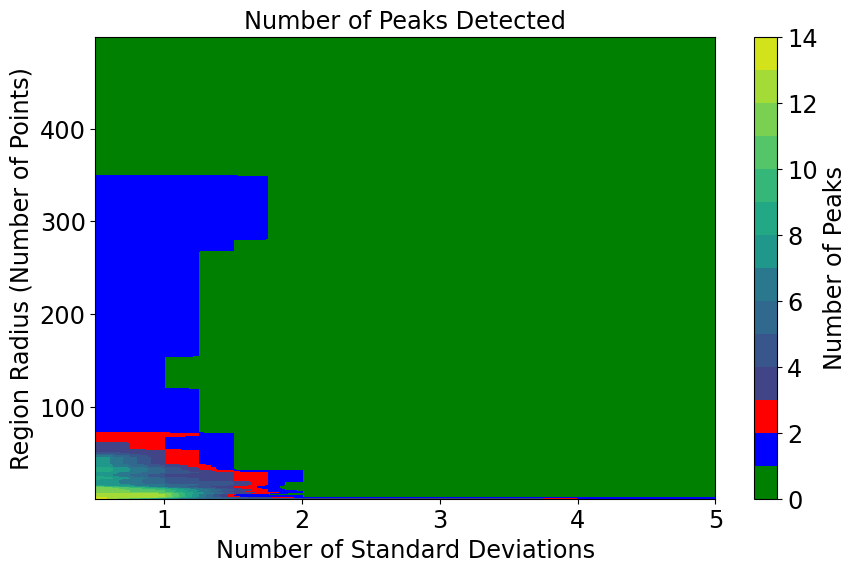

In [53]:
# Find maximum number of peaks detected in any region
max_peaks = int(peak_counts_R2.max()+1)

# Colour mapping
colour_list = ["green","blue", "red"] + [cm.viridis(i/max_peaks) for i in range(3, max_peaks)]
cmap_R2 = mcolors.LinearSegmentedColormap.from_list("custom", colour_list, N=max_peaks)

# Create a contour plot of region_radius and std_dev vs. number of peaks found
plt.figure(figsize=(10,6))
plt.contourf(std_devs, region_sizes, peak_counts_R2, levels=max_peaks, cmap=cmap_R2)
plt.xlabel('Number of Standard Deviations')
plt.ylabel('Region Radius (Number of Points)')
plt.title('Number of Peaks Detected')
plt.colorbar(label='Number of Peaks')
plt.show()

Okay. So, it looks like the optimized parameters are different in the different cases. Ideally, we want an algorithm with just one set of parameters. So, what overlap do these two optimal solutions have?

In [54]:
# Convert lists of tuples to sets
set1 = set(optimal_pairs_R1)
set2 = set(optimal_pairs_R2)

# Find common pairs
common_pairs = list(set1 & set2)

print("We found "+ str(len(common_pairs)) + " pair(s) that might optimize both windows of data.")

We found 202 pair(s) that might optimize both windows of data.


Oh, thankfully, an absolute ton.

Let's look at them all. Here is a little function to make the plots for me.

In [55]:
def create_plot(ax, x, y, pairs, region_name):
    ax.plot(x, y, label='Data')

    for std_dev, region_radius in pairs:
        peaks = find_significant_peaks(y, 0.01, std_dev, region_radius)
        ax.plot([x[i] for i in peaks], [y[i] for i in peaks], 'o', label=f'Peaks (radius={region_radius}, std_dev={std_dev})')

    ax.set_ylim([0,max(y)+max(y)/10])
    ax.set_title(f'{region_name} with Identified Peaks')


Let's use it now.

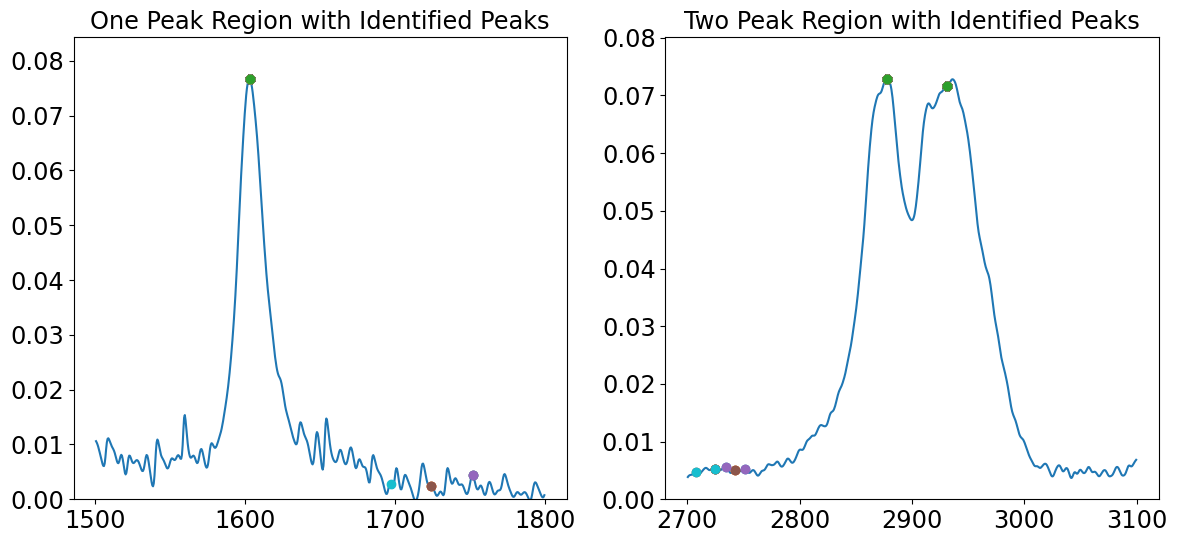

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot with peaks for each pair of parameters
create_plot(ax1, x_R1, y_R1, common_pairs, 'One Peak Region')

# Plot with peaks for each pair of parameters
create_plot(ax2, x_R2, y_R2, common_pairs, 'Two Peak Region')

plt.show()

## PRACTICE QUESTION



What is the above telling us?


---


**notes**



---

It looks like we have many optimal solutions, but some, unfortunately, will still grab noise.

Typically, we assign a cut-off to what is a possible peak to even consider. This cut-off is related to the limit of detection or quantification of the instrument. We will go into how this is quantified more (it connects to basic stats again!) when we talk about random numbers. For now, we can just add a peak cut off (anything smaller than some percent of the max signal is probably not real).

In [57]:
def find_significant_peaks(y, derivative_threshold_percent, standard_deviations, region_radius, peak_height_percentage = 0.05):
    # Calculate the approximate derivative
    dy = np.abs(np.diff(y))

    # Find maximum change in y and set derivative threshold relative to the maximum change
    max_dy = np.max(dy)
    derivative_threshold = derivative_threshold_percent * max_dy

    # Calculate the peak height.
    peak_height = peak_height_percentage * np.max(y)

    peaks = []
    start = None

    for i in range(1, len(y)):
        if dy[i-1] < derivative_threshold and start is None:
            # We are at the start of a flat region
            start = i
        elif dy[i-1] >= derivative_threshold and start is not None:
            # We are at the end of a flat region
            end = i

            # Verify position allows for a full surrounding region
            if start - region_radius >= 0 and end + region_radius < len(y):
                # Identify region and calculate mean and standard deviation
                region = y[start:end]
                region_mean = np.mean(region)
                region_stddev = np.std(region)

                # Find maximum value within region; if it is less than the correct percentage of maximum y, skip this region
                max_region = np.max(region)
                if max_region < peak_height:
                    start = None
                    continue

                surrounding_region = np.concatenate((y[start-region_radius:start], y[end:end+region_radius]))
                surrounding_mean = np.mean(surrounding_region)
                surrounding_stddev = np.std(surrounding_region)

                # Check if the region mean is significantly greater than the mean of the surrounding regions
                if region_mean + standard_deviations*region_stddev > surrounding_mean + standard_deviations*surrounding_stddev:
                    # Find maximum value within region as the peak
                    peak_index = start + np.argmax(region)
                    # Append the index of the peak value to the list
                    peaks.append(peak_index)

            start = None

    return peaks

Let's re-run the optimization now.

In [58]:
# Define range of region_radius and standard_deviations values to explore
region_sizes = range(1, 500)
std_devs = np.arange(0.5, 5.5, 0.5)

##################### For the one peak region #####################
# Initialize a matrix to save the number of peaks found
peak_counts_R1 = np.zeros((len(region_sizes), len(std_devs)))

# Initialize a list to store pairs (region_size, std_dev) that result in 1 peak
optimal_pairs_R1 = []

# Loop over region sizes and standard deviations
for i, size in enumerate(region_sizes):
    for j, std_dev in enumerate(std_devs):
        peaks = find_significant_peaks(y_R1, 0.01, std_dev, size, peak_height_percentage = 0.05)
        peak_counts_R1[i, j] = len(peaks)
        # If the number of peaks is exactly 1, save the region size and std_dev pair
        if peak_counts_R1[i, j] == 1:
            optimal_pairs_R1.append((std_dev, size))

##################### For the two peak region #####################
# Initialize a matrix to save the number of peaks found
peak_counts_R2 = np.zeros((len(region_sizes), len(std_devs)))

# Initialize a list to store pairs (region_size, std_dev) that result in 1 peak
optimal_pairs_R2 = []

# Loop over region sizes and standard deviations
for i, size in enumerate(region_sizes):
    for j, std_dev in enumerate(std_devs):
        peaks = find_significant_peaks(y_R2, 0.01, std_dev, size, peak_height_percentage = 0.05 )
        peak_counts_R2[i, j] = len(peaks)
        # If the number of peaks is exactly 2, save the region size and std_dev pair
        if peak_counts_R2[i, j] == 2:
            optimal_pairs_R2.append((std_dev, size))

##################### Find Common Pairs #####################
# Convert lists of tuples to sets
set1 = set(optimal_pairs_R1)
set2 = set(optimal_pairs_R2)

# Find common pairs
common_pairs = list(set1 & set2)

print("We found "+ str(len(common_pairs)) + " pair(s) that might optimize both windows of data.")

We found 199 pair(s) that might optimize both windows of data.


So we still have a lot of good options...

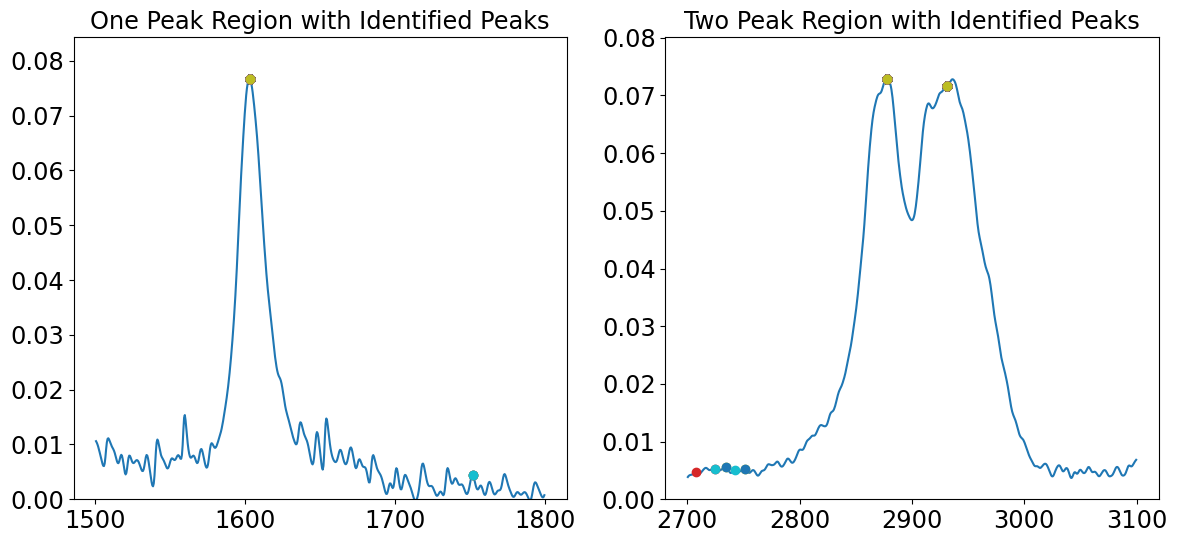

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot with peaks for each pair of parameters
create_plot(ax1, x_R1, y_R1, common_pairs, 'One Peak Region')

# Plot with peaks for each pair of parameters
create_plot(ax2, x_R2, y_R2, common_pairs, 'Two Peak Region')

plt.show()

Darn, still some noise remains... But some parameter pairs don't pick up any noise.

Like the example below.

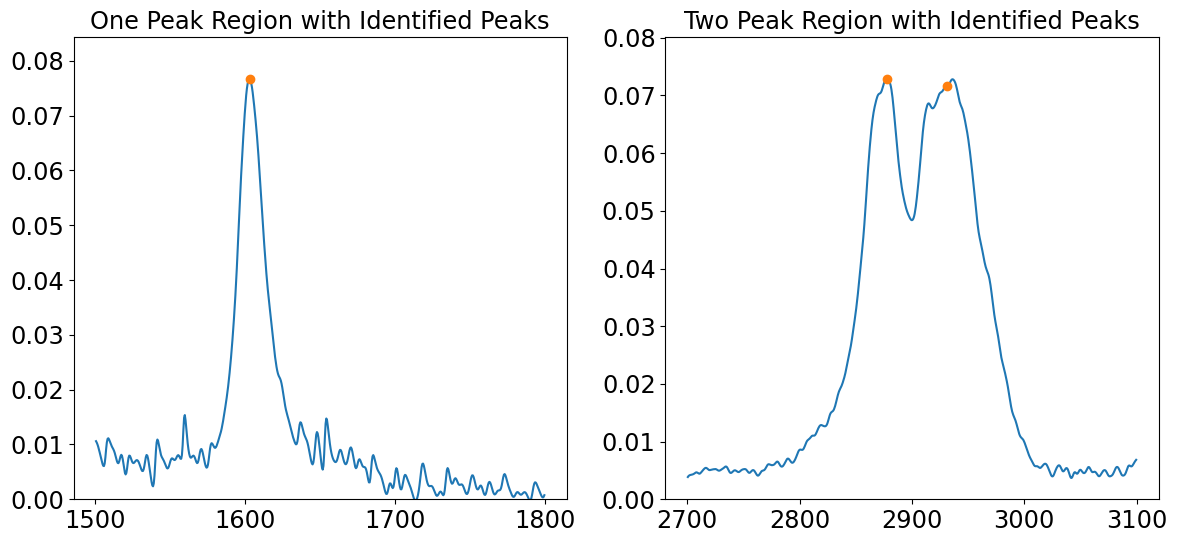

In [60]:
common_pairs=[(1,100)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot with peaks for each pair of parameters
create_plot(ax1, x_R1, y_R1, common_pairs, 'One Peak Region')

# Plot with peaks for each pair of parameters
create_plot(ax2, x_R2, y_R2, common_pairs, 'Two Peak Region')

plt.show()

Will this work for the entire spectra though?? You will find out!

# Recap

Our goal is to say something meaningful and quantitative about the IR spectra.

We can fit peaks (find the expression for Gaussians or Double-Gaussians describing the spectra's peaks). This can give us nice, quantitative ways to compare two spectra (like the difference between the deuterated and non-deuterated examples we have here). We will also want this information when we find the area under said peaks in a later class (when you have two overlapping peaks, without the fit, you can't assign areas to the individual peaks!).

We know we often need to correct the baseline of spectra. Would a baseline correction apply across the entire spectra? Or need to be done in windows? How different do the baselines look for the two regions we examined above?

We know we can localize peaks using the notion of 'flat' regions, but we need some extra heuristics for what makes something a peak vs noise (this usually requires some domain knowledge).

Could you put these pieces together to start telling the story from Prof. Kathy's data??

(Yes, yes you can).

But spoilers, Prof. Kathy's talk ended with "Future work: Experimental and computational characterization of *pink stuff*", so this mystery is not over yet!



---



# Submit your notebook

It's time to download your notebook and submit it on Canvas. Go to the File menu and click **Download** -> **Download .ipynb**

Then, go to **Canvas** and **submit your assignment** on the assignment page. Once it is submitted, swing over to the homework now and start working through the paper.